<a href="https://colab.research.google.com/github/grahamriley2/ThinkfulDS/blob/main/Spotify_Song_Segmentation_DS_Capstone.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setup and EDA

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture

In [ ]:
#load data and store as new dataframe
df_spotify = pd.read_csv('https://raw.githubusercontent.com/grahamriley2/ThinkfulDS/main/data.csv')
df_spotify.head()

acousticness                                   artists  danceability  \
0         0.995                       ['Carl Woitschach']         0.708   
1         0.994  ['Robert Schumann', 'Vladimir Horowitz']         0.379   
2         0.604                   ['Seweryn Goszczyński']         0.749   
3         0.995                      ['Francisco Canaro']         0.781   
4         0.990  ['Frédéric Chopin', 'Vladimir Horowitz']         0.210   

   duration_ms  energy  explicit                      id  instrumentalness  \
0       158648  0.1950         0  6KbQ3uYMLKb5jDxLF7wYDD             0.563   
1       282133  0.0135         0  6KuQTIu1KoTTkLXKrwlLPV             0.901   
2       104300  0.2200         0  6L63VW0PibdM1HDSBoqnoM             0.000   
3       180760  0.1300         0  6M94FkXd15sOAOQYRnWPN8             0.887   
4       687733  0.2040         0  6N6tiFZ9vLTSOIxkj8qKrd             0.908   

   key  liveness  loudness  mode  \
0   10    0.1510   -12.428     1   
1    8    0.0763   -28.454     1   
2    5    0.1190   -19.924     0   
3    1    0.1110   -14.734     0   
4   11    0.0980   -16.829     1   

                                            name  popularity release_date  \
0                    Singende Bataillone 1. Teil           0         1928   
1       Fantasiestücke, Op. 111: Più tosto lento           0         1928   
2                 Chapter 1.18 - Zamek kaniowski           0         1928   
3  Bebamos Juntos - Instrumental (Remasterizado)           0   1928-09-25   
4    Polonaise-Fantaisie in A-Flat Major, Op. 61           1         1928   

   speechiness    tempo  valence  year  
0       0.0506  118.469   0.7790  1928  
1       0.0462   83.972   0.0767  1928  
2       0.9290  107.177   0.8800  1928  
3       0.0926  108.003   0.7200  1928  
4       0.0424   62.149   0.0693  1928

In [ ]:
#Examine the dataframe
df_spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 169909 entries, 0 to 169908
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   acousticness      169909 non-null  float64
 1   artists           169909 non-null  object 
 2   danceability      169909 non-null  float64
 3   duration_ms       169909 non-null  int64  
 4   energy            169909 non-null  float64
 5   explicit          169909 non-null  int64  
 6   id                169909 non-null  object 
 7   instrumentalness  169909 non-null  float64
 8   key               169909 non-null  int64  
 9   liveness          169909 non-null  float64
 10  loudness          169909 non-null  float64
 11  mode              169909 non-null  int64  
 12  name              169909 non-null  object 
 13  popularity        169909 non-null  int64  
 14  release_date      169909 non-null  object 
 15  speechiness       169909 non-null  float64
 16  tempo             16

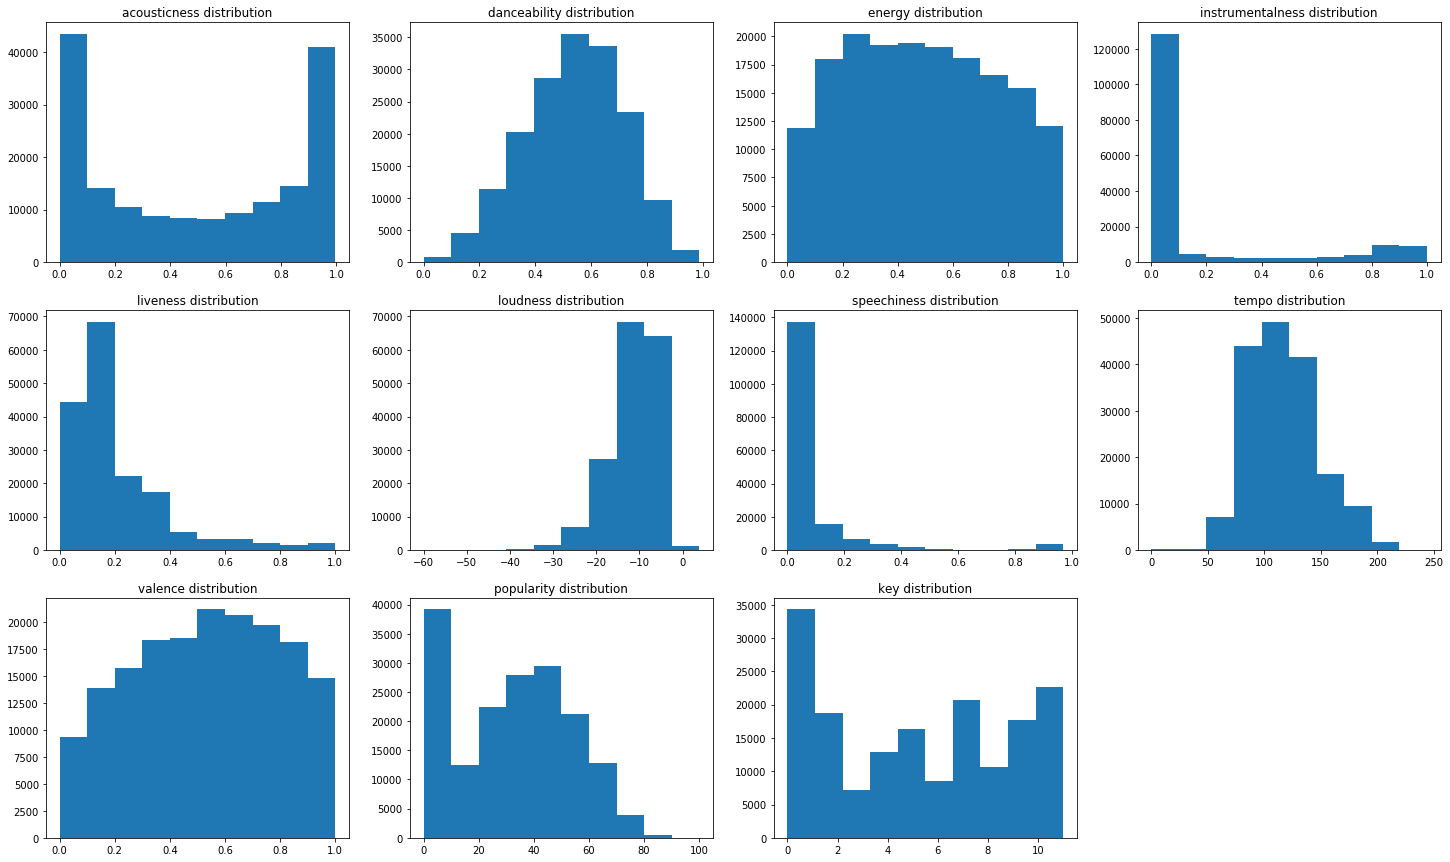

In [ ]:
#Check the distribution of features by plotting a histogram for each one
plt.rcParams['figure.figsize'] = [25,15]

features = ['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','popularity','key']

for i in np.arange(0,11):
  plt.subplot(3,4,i+1)
  plt.title(f'{features[i]} distribution')
  plt.hist(df_spotify[features[i]])


In [ ]:
#standardize numeric features and store in new dataframe
df_std = pd.DataFrame()

scaler = StandardScaler()
df_columns_removed = df_spotify.drop(['artists','id','name','release_date','year'],axis=1)
for col in df_columns_removed.columns:
  new_column = scaler.fit_transform(df_spotify[[col]])
  df_std[col] = new_column[:,0]

df_std.head(10)

acousticness  danceability  duration_ms    energy  explicit  \
0      1.332319      0.968662    -0.599713 -1.097999  -0.30452   
1      1.329664     -0.907636     0.418119 -1.776785  -0.30452   
2      0.294154      1.202486    -1.047680 -1.004503  -0.30452   
3      1.332319      1.384983    -0.417454 -1.341091  -0.30452   
4      1.319044     -1.871449     3.761300 -1.064341  -0.30452   
5      1.332319     -0.651000     0.998947 -1.378490  -0.30452   
6      1.228768     -0.536939    -0.781223 -1.090520  -0.30452   
7      1.313733      0.096098    -0.638297 -0.252789  -0.30452   
8      1.332319      0.826086    -0.568021 -1.053121  -0.30452   
9      0.936701      0.774759    -0.987509 -1.060601  -0.30452   

   instrumentalness       key  liveness  loudness      mode  popularity  \
0          1.296562  1.365333 -0.314998 -0.186652  0.641344   -1.462135   
1          2.389253  0.796383 -0.737519 -3.014729  0.641344   -1.462135   
2         -0.523513 -0.057043 -0.495997 -1.509457 -1.559227   -1.462135   
3          2.343994 -1.194943 -0.541247 -0.593587 -1.559227   -1.462135   
4          2.411883  1.649808 -0.614778 -0.963288  0.641344   -1.415802   
5          2.421581  0.227432 -0.651544 -1.389105 -1.559227   -1.462135   
6          0.882762  1.649808 -0.748266 -1.033346  0.641344   -1.462135   
7          2.179120 -1.194943 -0.575185  0.263341  0.641344   -1.462135   
8          0.142447  1.080858  0.737062  0.276929 -1.559227   -1.462135   
9         -0.523513  1.080858 -0.207529 -1.543868  0.641344   -1.462135   

   speechiness     tempo   valence  
0    -0.289840  0.049500  0.940924  
1    -0.319186 -1.073199 -1.735454  
2     5.568626 -0.317996  1.325822  
3    -0.009722 -0.291114  0.716082  
4    -0.344530 -1.783425 -1.763655  
5    -0.231816 -1.738773 -1.014056  
6    -0.360536 -1.186357 -0.865431  
7    -0.311182  0.207050  1.238172  
8     0.219708  0.093891 -0.148987  
9     5.735363 -1.161818  0.864706

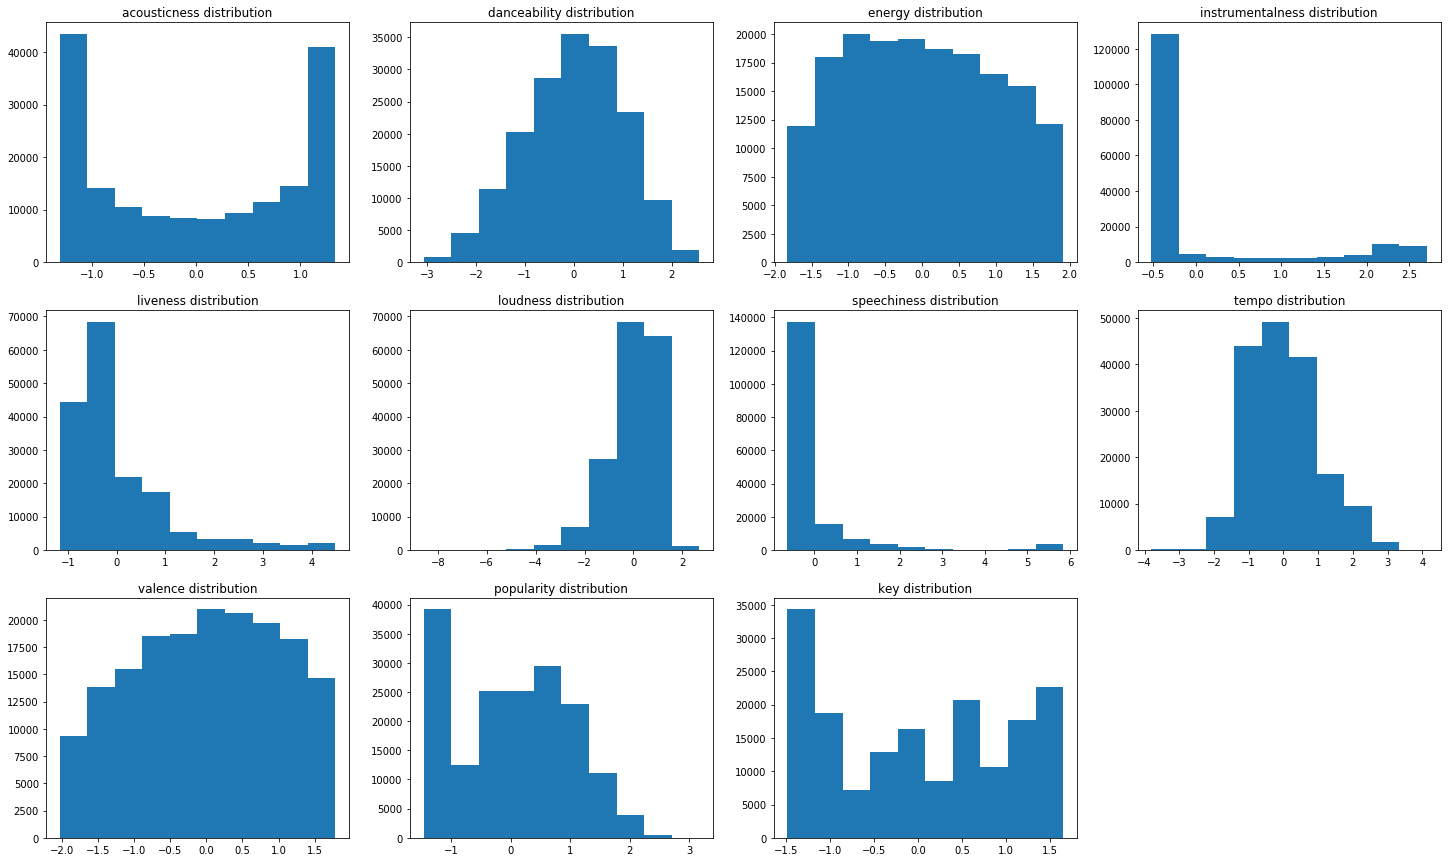

In [ ]:
#check the distributions of the standardized features
plt.rcParams['figure.figsize'] = [25,15]

features = ['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','popularity','key']

for i in np.arange(0,11):
  plt.subplot(3,4,i+1)
  plt.title(f'{features[i]} distribution')
  plt.hist(df_std[features[i]])


# Apply PCA to the data to reduce dimensionality

In [ ]:
#apply PCA to the standardized dataframe
pca = PCA(n_components=2)
pca_components = pca.fit_transform(df_std)

#create empty dataframe
df_pca = pd.DataFrame()

#add the components to the empty dataframe
df_pca['component1'] = pca_components[:,0]
df_pca['component2'] = pca_components[:,1]

df_pca.head()

component1  component2
0    1.596609   -1.251392
1    4.878272    0.164726
2    0.791946   -5.278548
3    2.189194   -1.532315
4    4.082529    2.008539

# Implement the KMeans Model using the Principal Components

In [ ]:
import time
start_time = time.time()

#run kmeans algorithm with a range of values for the n_clusters hyperparameter
for i in np.arange(2,10):
  kmeans = KMeans(n_clusters = i, random_state=42)
  kmeans.fit(df_pca)
    
  #For each loop, print the silhouette score
  y_pred = kmeans.predict(df_pca)
  sil_score = metrics.silhouette_score(df_pca,y_pred)
  print(f'The silhouette score for K-Means with {i} clusters is {sil_score}')

print("runtime:%s seconds" % (time.time() - start_time))

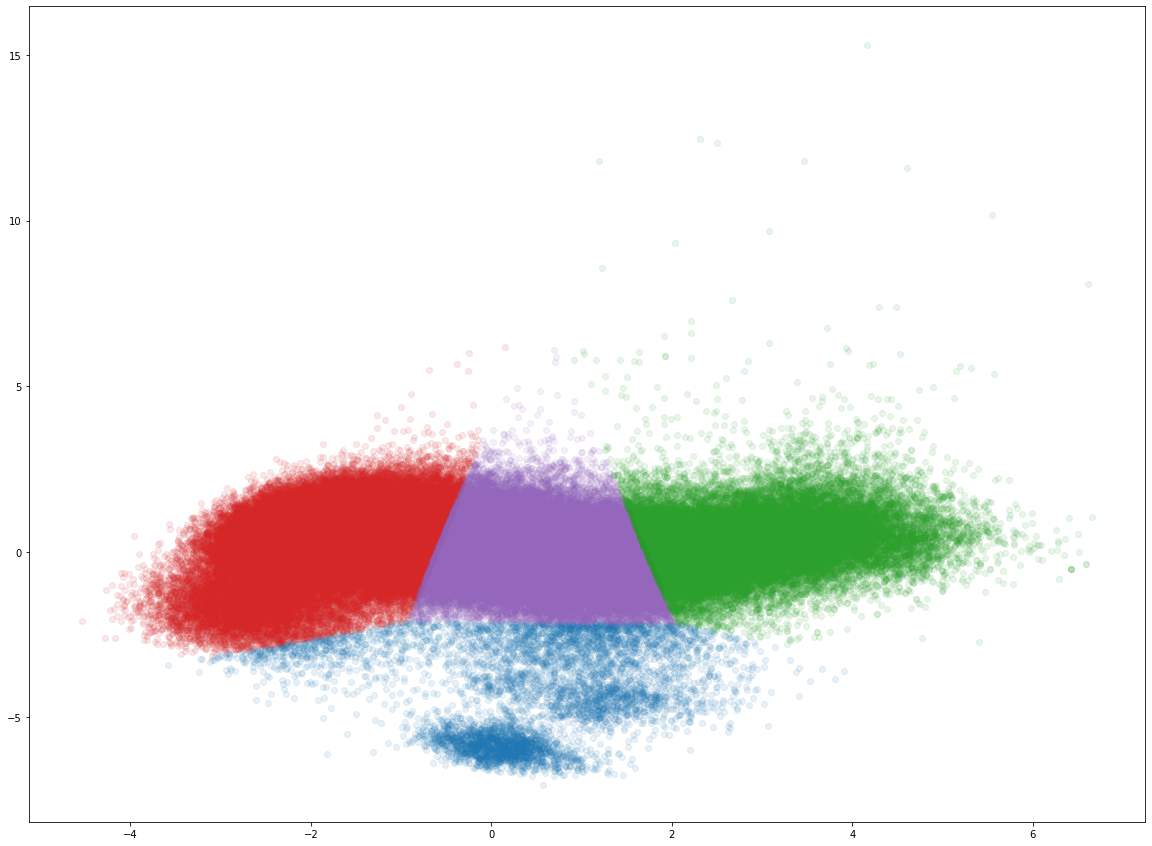

In [ ]:
#Run kmeans with the optimal number of clusters
kmeans = KMeans(n_clusters = 4, random_state=42)
kmeans.fit(df_pca)
y_pred = kmeans.predict(df_pca)

#create a copy of the PCA dataframe and add a feature for the cluster identified by the kmeans algorithm
df_pca_clusters = df_pca.copy()
df_pca_clusters['cluster'] = y_pred

#create sub dataframes for each cluster
df_pca_clust1 = df_pca_clusters[df_pca_clusters['cluster']==0]
df_pca_clust2 = df_pca_clusters[df_pca_clusters['cluster']==1]
df_pca_clust3 = df_pca_clusters[df_pca_clusters['cluster']==2]
df_pca_clust4 = df_pca_clusters[df_pca_clusters['cluster']==3]

plt.figure(figsize=(20,15))

#plot the four clusters as four different colors
plt.scatter(df_pca_clust1['component1'],df_pca_clust1['component2'],c='Tab:Blue', alpha=.1)
plt.scatter(df_pca_clust2['component1'],df_pca_clust2['component2'],c='Tab:Red', alpha=.1)
plt.scatter(df_pca_clust3['component1'],df_pca_clust3['component2'],c='Tab:Purple', alpha=.1)
plt.scatter(df_pca_clust4['component1'],df_pca_clust4['component2'],c='Tab:Green', alpha=.1)

There doesn't seem to be much separation between the clusters. It sort of seems as though the KMeans algorithm selected boundaries at random.

In [ ]:
df_spotify_iter1 = df_spotify.copy()

#Add the KMeans cluster results as a new feature to the original spotify dataframe
df_spotify_iter1['cluster'] = y_pred

#Create a separate dataframe for each cluster
clust1_iter1 = df_spotify_iter1[df_spotify_iter1['cluster']==0]
clust2_iter1 = df_spotify_iter1[df_spotify_iter1['cluster']==1]
clust3_iter1 = df_spotify_iter1[df_spotify_iter1['cluster']==2]
clust4_iter1 = df_spotify_iter1[df_spotify_iter1['cluster']==3]

#Create a series for each cluster with the means for each feature
clust1_means = clust1_iter1.mean()
clust2_means = clust2_iter1.mean()
clust3_means = clust3_iter1.mean()
clust4_means = clust4_iter1.mean()

#Create dataframe with clusters as index and nunerical features as columns
df_means_by_cluster = pd.DataFrame([clust1_means,clust2_means,clust3_means,clust4_means],index=['Cluster 1','Cluster 2','Cluster 3','Cluster 4'],columns=clust1_means.index)
df_means_by_cluster.head()

acousticness  danceability    duration_ms    energy  explicit  \
Cluster 1      0.564712      0.693226  171093.302402  0.277161  0.447845   
Cluster 2      0.168553      0.599716  237177.108916  0.721808  0.152411   
Cluster 3      0.663462      0.541343  219071.556672  0.391936  0.006106   
Cluster 4      0.920732      0.365627  250521.251263  0.167231  0.000302   

           instrumentalness       key  liveness   loudness      mode  \
Cluster 1          0.038797  5.371833  0.296763 -16.760733  0.635406   
Cluster 2          0.046057  5.333884  0.208368  -7.281971  0.684027   
Cluster 3          0.132497  5.138245  0.207086 -11.965368  0.742767   
Cluster 4          0.495566  4.974958  0.185684 -18.567566  0.718917   

           popularity  speechiness       tempo   valence         year  cluster  
Cluster 1    8.438138     0.726315  107.368191  0.603841  1950.417901      0.0  
Cluster 2   46.410661     0.085548  125.107813  0.615620  1995.189603      1.0  
Cluster 3   25.133666     0.061227  116.463874  0.557402  1968.491995      2.0  
Cluster 4   13.316710     0.052932  101.167560  0.287784  1956.588991      3.0

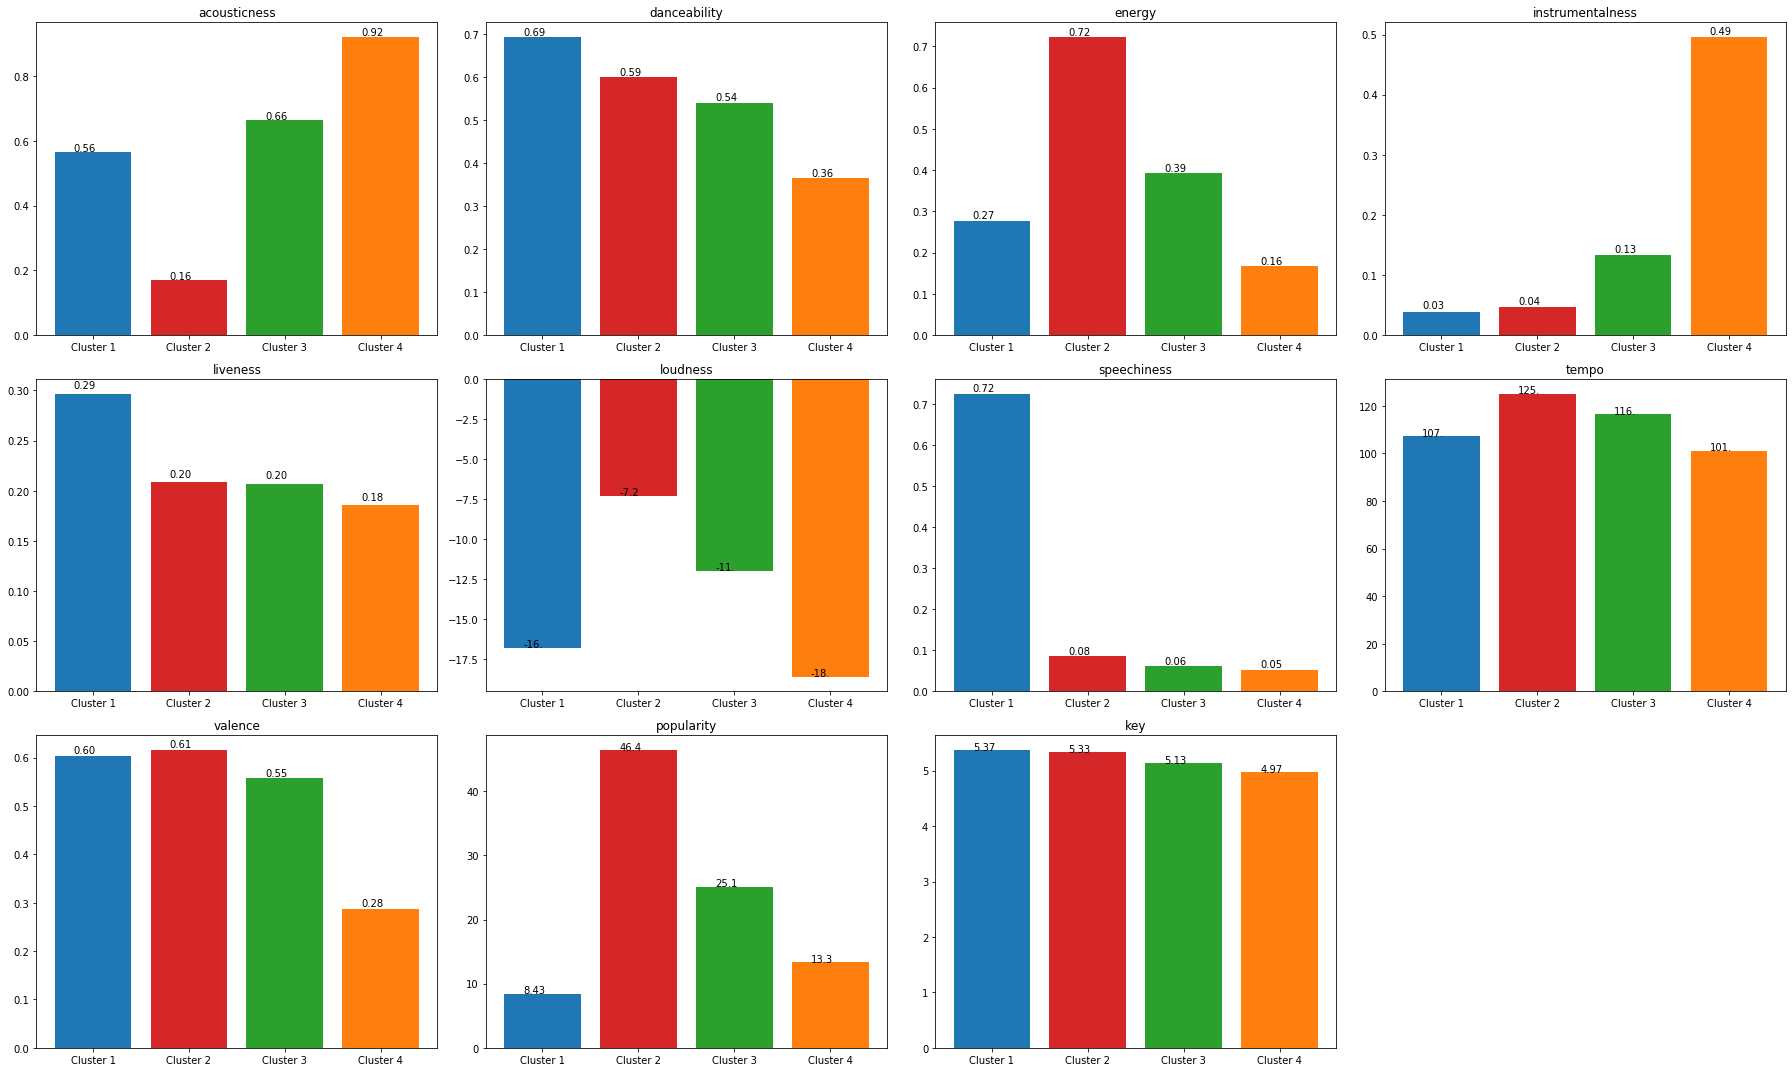

In [ ]:
#Create a list of cluster numbers
clusters = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4'] 

#Create a list of the features
features = ['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','popularity','key']

plt.rcParams['figure.figsize'] = [25,15]

#plot a bar graph for each feature that shows the mean value of each cluster
for i in np.arange(0,11):
  plt.subplot(3,4,i+1)
  plt.title(features[i])
  plt.bar(clusters,df_means_by_cluster[features[i]],color = ['tab:blue','tab:red','tab:green','tab:orange'])

  #add labels to each bar
  for n in np.arange(0,4):
    y_val = df_means_by_cluster.loc[clusters[n],features[i]]
    plt.text(x=n-.2,y=(y_val+.005),s=str(y_val)[0:4])    
  
plt.tight_layout()
plt.show()

A few observations on the above clusters:


# Run the DBSCAN Model using the Principal Components as inputs

In [ ]:
df_pca.head()

In [ ]:
start_time = time.time()

#Set the range of values to try for eps
eps_vals = [.1,.2,.5,1]

#Set the range of values to try for min_samples
min_samples_vals = [1,5,10,20]

#Run a loop of DBSCAN models, trying a different value for the eps and min_samples hyperparameters each time
for i in eps_vals:
    for n in min_samples_vals:
        dbscan = DBSCAN(eps=i, min_samples = n, metric='euclidean')
        y_pred = dbscan.fit_predict(df_pca)

        #For each loop, print the number of clusters
        count_clusters = len(np.unique(y_pred))
        print(f'Number of clusters when eps = {i} & min_samples = {n}: {count_clusters}')

        #For each loop, print the silhouette score
        sil_score = metrics.silhouette_score(df_pca,y_pred)
        print(f'   The silhouette score with eps = {i} & min_samples = {n}: {sil_score}')

print("runtime:%s seconds" % (time.time() - start_time))

In [ ]:
#Run the DBSCAN model with the optimal hyperparameters and store the clusters as variable 'y_pred'
dbscan = DBSCAN(eps=1, min_samples = 1, metric='euclidean')
y_pred = dbscan.fit_predict(df_pca)

#For each loop, print the number of clusters
count_clusters = len(np.unique(y_pred))
print(f'Number of clusters when eps = .5 & min_samples = 5: {count_clusters}')

#For each loop, print the silhouette score
sil_score = metrics.silhouette_score(df_pca,y_pred)
print(f'   The silhouette score with eps = .5 & min_samples = 5: {sil_score}')

Number of clusters when eps = .5 & min_samples = 5: 11
   The silhouette score with eps = .5 & min_samples = 5: 0.6824907372266171


In [ ]:
np.unique(y_pred)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [ ]:
#create a copy of the PCA dataframe and add a feature for the cluster identified by the kmeans algorithm
df_pca_clusters['cluster'] = y_pred

In [ ]:
cluster_sizes = df_pca_clusters['cluster'].value_counts().to_frame()

cluster_sizes

cluster
0    169898
6         2
10        1
9         1
8         1
7         1
5         1
4         1
3         1
2         1
1         1

In [ ]:
#create sub dataframes for each cluster
df_pca_clust1 = df_pca_clusters[df_pca_clusters['cluster']==0]
df_pca_clust2 = df_pca_clusters[df_pca_clusters['cluster']==1]
df_pca_clust3 = df_pca_clusters[df_pca_clusters['cluster']==2]
df_pca_clust4 = df_pca_clusters[df_pca_clusters['cluster']==3]
df_pca_clust5 = df_pca_clusters[df_pca_clusters['cluster']==4]
df_pca_clust6 = df_pca_clusters[df_pca_clusters['cluster']==5]
df_pca_clust7 = df_pca_clusters[df_pca_clusters['cluster']==6]
df_pca_clust8 = df_pca_clusters[df_pca_clusters['cluster']==7]
df_pca_clust9 = df_pca_clusters[df_pca_clusters['cluster']==8]
df_pca_clust10 = df_pca_clusters[df_pca_clusters['cluster']==9]
df_pca_clust11 = df_pca_clusters[df_pca_clusters['cluster']==10]

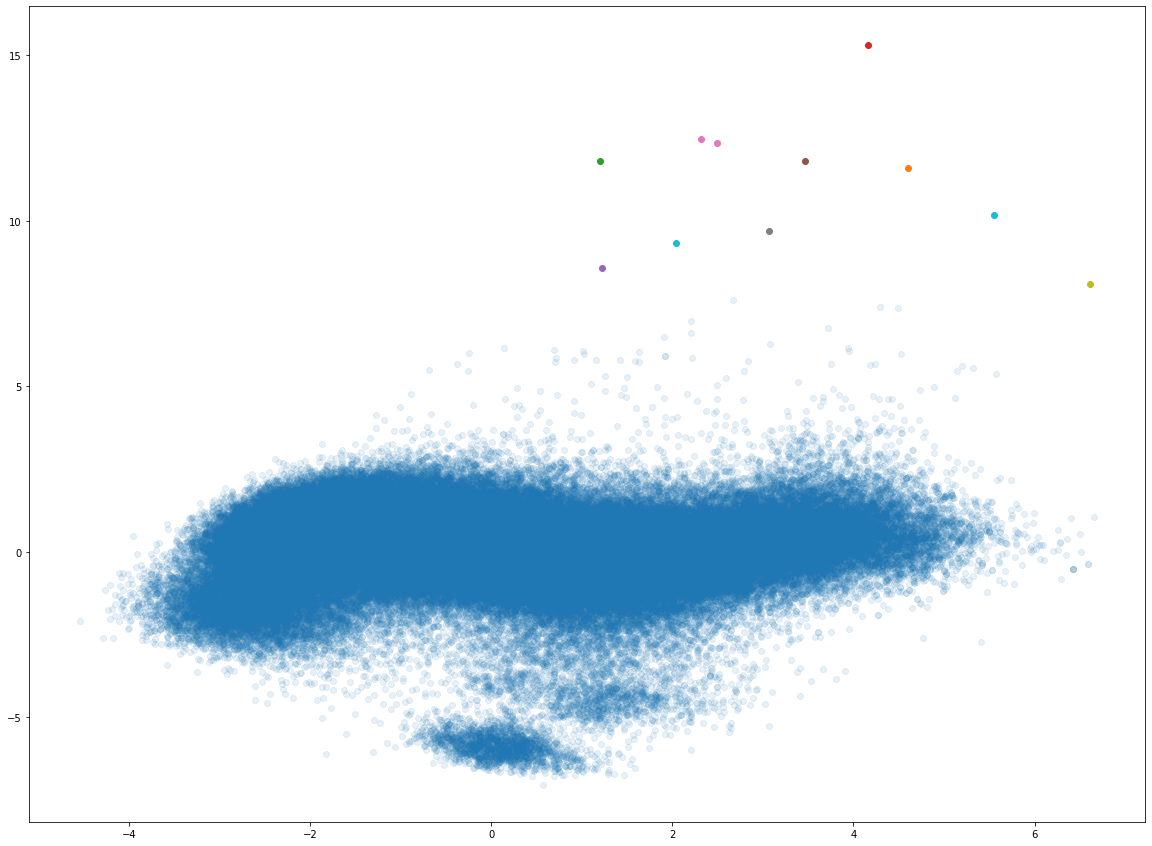

In [ ]:
plt.figure(figsize=(20,15))

#plot the four clusters as five different colors
plt.scatter(df_pca_clust1['component1'],df_pca_clust1['component2'],c='Tab:Blue', alpha=.1)
plt.scatter(df_pca_clust2['component1'],df_pca_clust2['component2'],c='Tab:Red', alpha=1)
plt.scatter(df_pca_clust3['component1'],df_pca_clust3['component2'],c='Tab:Purple', alpha=1)
plt.scatter(df_pca_clust4['component1'],df_pca_clust4['component2'],c='Tab:Green', alpha=1)
plt.scatter(df_pca_clust5['component1'],df_pca_clust5['component2'],c='Tab:Orange', alpha=1)
plt.scatter(df_pca_clust6['component1'],df_pca_clust6['component2'],c='Tab:Brown', alpha=1)
plt.scatter(df_pca_clust7['component1'],df_pca_clust7['component2'],c='Tab:Pink', alpha=1)
plt.scatter(df_pca_clust8['component1'],df_pca_clust8['component2'],c='Tab:Gray', alpha=1)
plt.scatter(df_pca_clust9['component1'],df_pca_clust9['component2'],c='Tab:Olive', alpha=1)
plt.scatter(df_pca_clust10['component1'],df_pca_clust10['component2'],c='Tab:Cyan', alpha=1)
plt.scatter(df_pca_clust11['component1'],df_pca_clust11['component2'],c='Tab:Cyan', alpha=1)

In [ ]:
#Run the DBSCAN model with the optimal hyperparameters and store the clusters as variable 'y_pred'
dbscan = DBSCAN(eps=1, min_samples = 20, metric='euclidean')
y_pred = dbscan.fit_predict(df_pca)

#For each loop, print the number of clusters
count_clusters = len(np.unique(y_pred))
print(f'Number of clusters when eps = 1 & min_samples = 20: {count_clusters}')

#For each loop, print the silhouette score
sil_score = metrics.silhouette_score(df_pca,y_pred)
print(f'   The silhouette score with eps = 1 & min_samples = 20: {sil_score}')

Number of clusters when eps = 1 & min_samples = 20: 2
   The silhouette score with eps = 1 & min_samples = 20: 0.6952984083400056


In [ ]:
np.unique(y_pred)

array([-1,  0])

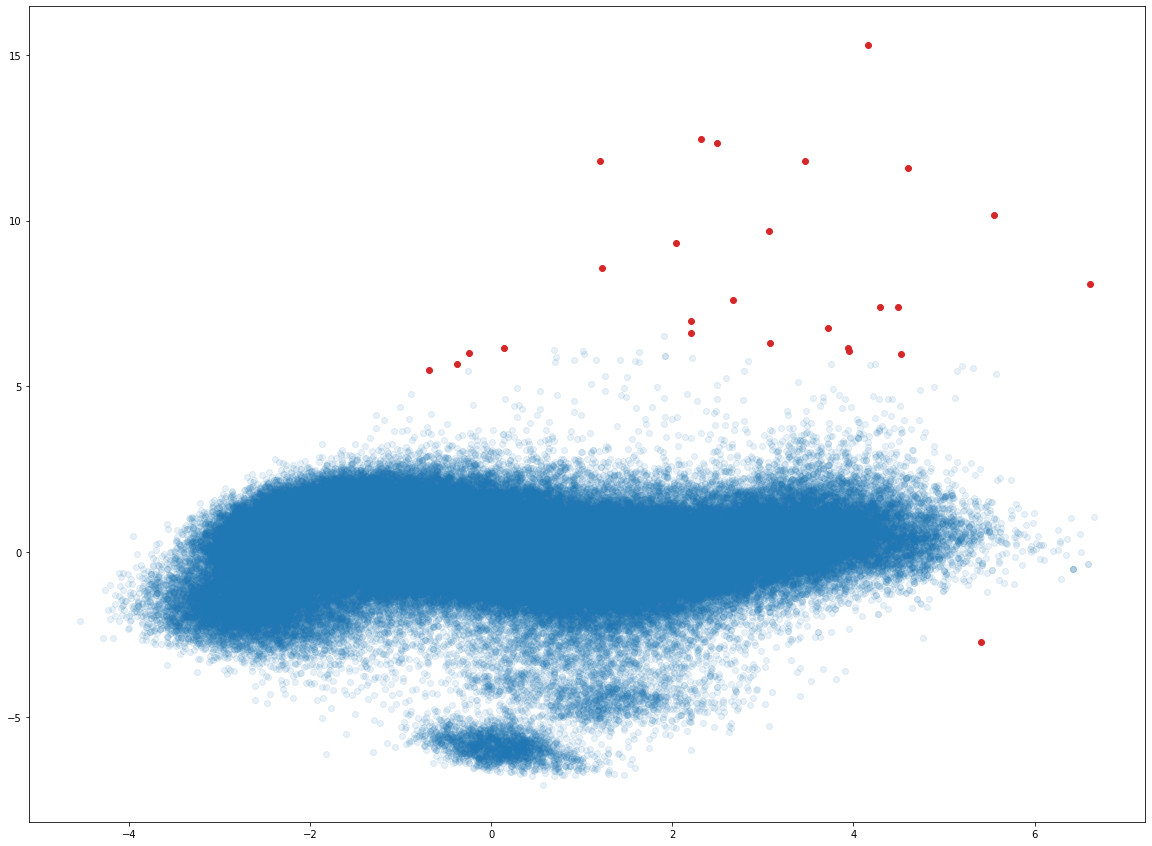

In [ ]:
#create a copy of the PCA dataframe and add a feature for the cluster identified by the kmeans algorithm
df_pca_clusters['cluster'] = y_pred

#create sub dataframes for each cluster
df_pca_clust1 = df_pca_clusters[df_pca_clusters['cluster']==0]
df_pca_clust2 = df_pca_clusters[df_pca_clusters['cluster']==-1]

plt.figure(figsize=(20,15))

#plot the four clusters as five different colors
plt.scatter(df_pca_clust1['component1'],df_pca_clust1['component2'],c='Tab:Blue', alpha=.1)
plt.scatter(df_pca_clust2['component1'],df_pca_clust2['component2'],c='Tab:Red', alpha=1)

Where is the fifth cluster? Let's explore.

# Run the GMM Model on the Principal Components

In [ ]:
from sklearn.mixture import GaussianMixture

start_time = time.time()

#run GMM algorithm with a range of values for the n_clusters
for i in np.arange(2,10):
  gmm = GaussianMixture(n_components = i, random_state=42)
  y_pred = gmm.fit_predict(df_pca)
    
  #For each loop, print the silhouette score
  sil_score = metrics.silhouette_score(df_pca,y_pred)
  print(f'The silhouette score for GMM with {i} clusters is {sil_score}')

print("runtime:%s seconds" % (time.time() - start_time))

In [ ]:
gmm = GaussianMixture(n_components = 3, random_state=42)
y_pred = gmm.fit_predict(df_pca)
    
#For each loop, print the silhouette score
sil_score = metrics.silhouette_score(df_pca,y_pred)
print(f'The silhouette score for GMM with 3 clusters is {sil_score}')

The silhouette score for GMM with 3 clusters is 0.4510527893100717


In [ ]:
df_pca_clusters.head()

component1  component2  cluster
0    1.596609   -1.251392        0
1    4.878272    0.164726        0
2    0.791946   -5.278548        0
3    2.189194   -1.532315        0
4    4.082529    2.008539        0

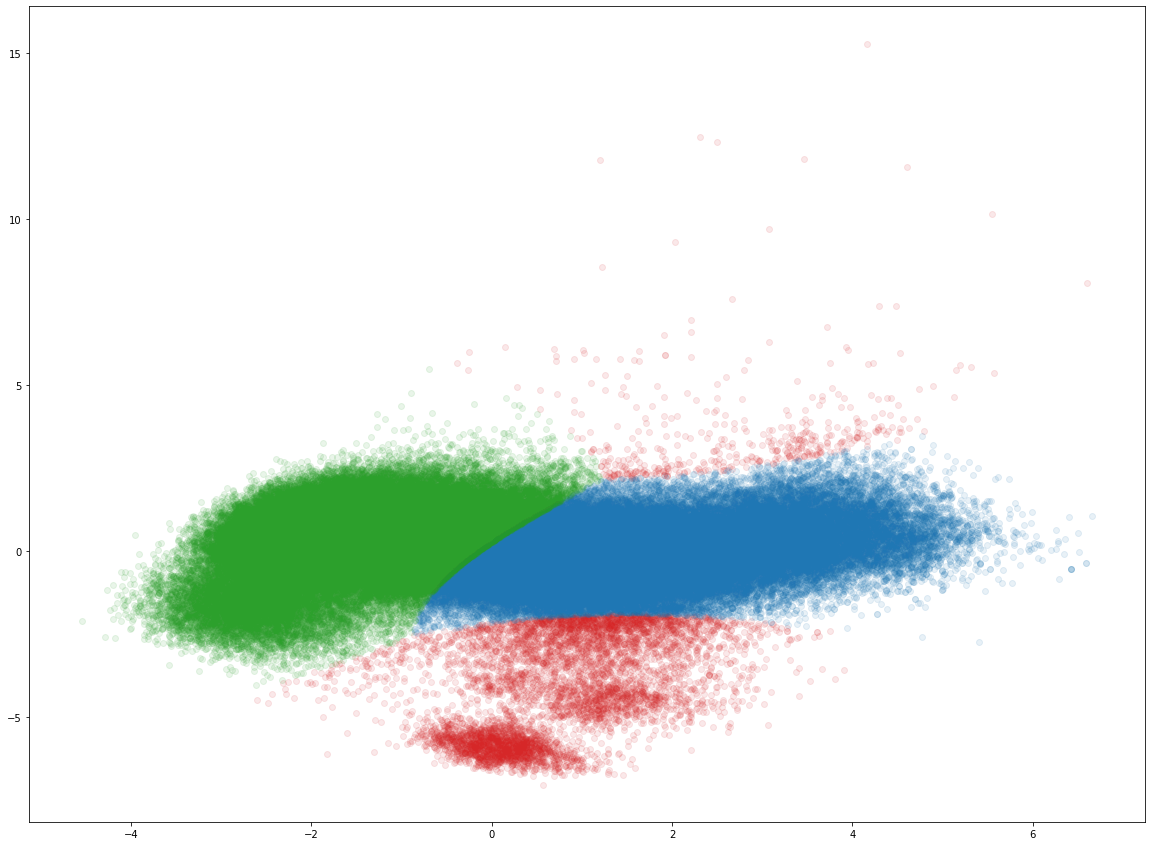

In [ ]:
#Set the 'cluster' feature in the t-SNE dataframe equal to the new clusters from the DBSCAN Model
df_pca_clusters['cluster'] = y_pred

#create sub dataframes for each cluster
df_pca_clust1 = df_pca_clusters[df_pca_clusters['cluster']==0]
df_pca_clust2 = df_pca_clusters[df_pca_clusters['cluster']==1]
df_pca_clust3 = df_pca_clusters[df_pca_clusters['cluster']==2]

plt.figure(figsize=(20,15))

#plot the 3 clusters as 3 different colors
plt.scatter(df_pca_clust1['component1'],df_pca_clust1['component2'],c='Tab:Red', alpha=.1)
plt.scatter(df_pca_clust2['component1'],df_pca_clust2['component2'],c='Tab:Blue', alpha=.1)
plt.scatter(df_pca_clust3['component1'],df_pca_clust3['component2'],c='Tab:Green', alpha=.1)

In [ ]:
df_spotify.head()

In [ ]:
df_spotify_iter3 = df_spotify.copy()

#Add the KMeans cluster results as a new feature to the original spotify dataframe
df_spotify_iter3['cluster'] = y_pred

#Create a separate dataframe for each cluster
clust1_iter3 = df_spotify_iter3[df_spotify_iter3['cluster']==0]
clust2_iter3 = df_spotify_iter3[df_spotify_iter3['cluster']==1]
clust3_iter3 = df_spotify_iter3[df_spotify_iter3['cluster']==2]

#Create a series for each cluster with the means for each feature
clust1_means = clust1_iter3.mean()
clust2_means = clust2_iter3.mean()
clust3_means = clust3_iter3.mean()

#Create dataframe with clusters as index and nunerical features as columns
df_means_by_cluster = pd.DataFrame([clust1_means,clust2_means,clust3_means],index=['Cluster 1','Cluster 2','Cluster 3'],columns=clust1_means.index)
df_means_by_cluster.head()

acousticness  danceability    duration_ms    energy  explicit  \
Cluster 1      0.631534      0.651578  236513.556968  0.253189  0.340899   
Cluster 2      0.826250      0.471979  219099.017078  0.270035  0.003516   
Cluster 3      0.209329      0.584165  241143.501813  0.685559  0.132836   

           instrumentalness       key  liveness   loudness      mode  \
Cluster 1          0.103984  5.267817  0.290993 -17.251444  0.655167   
Cluster 2          0.291981  5.086393  0.197256 -15.159913  0.729335   
Cluster 3          0.059341  5.289345  0.208228  -7.822384  0.695416   

           popularity  speechiness       tempo   valence         year  cluster  
Cluster 1    6.252686     0.661866  106.887024  0.575002  1947.262218      0.0  
Cluster 2   17.522162     0.058848  108.921063  0.452620  1960.399604      1.0  
Cluster 3   44.955688     0.081128  124.286311  0.594243  1993.257806      2.0

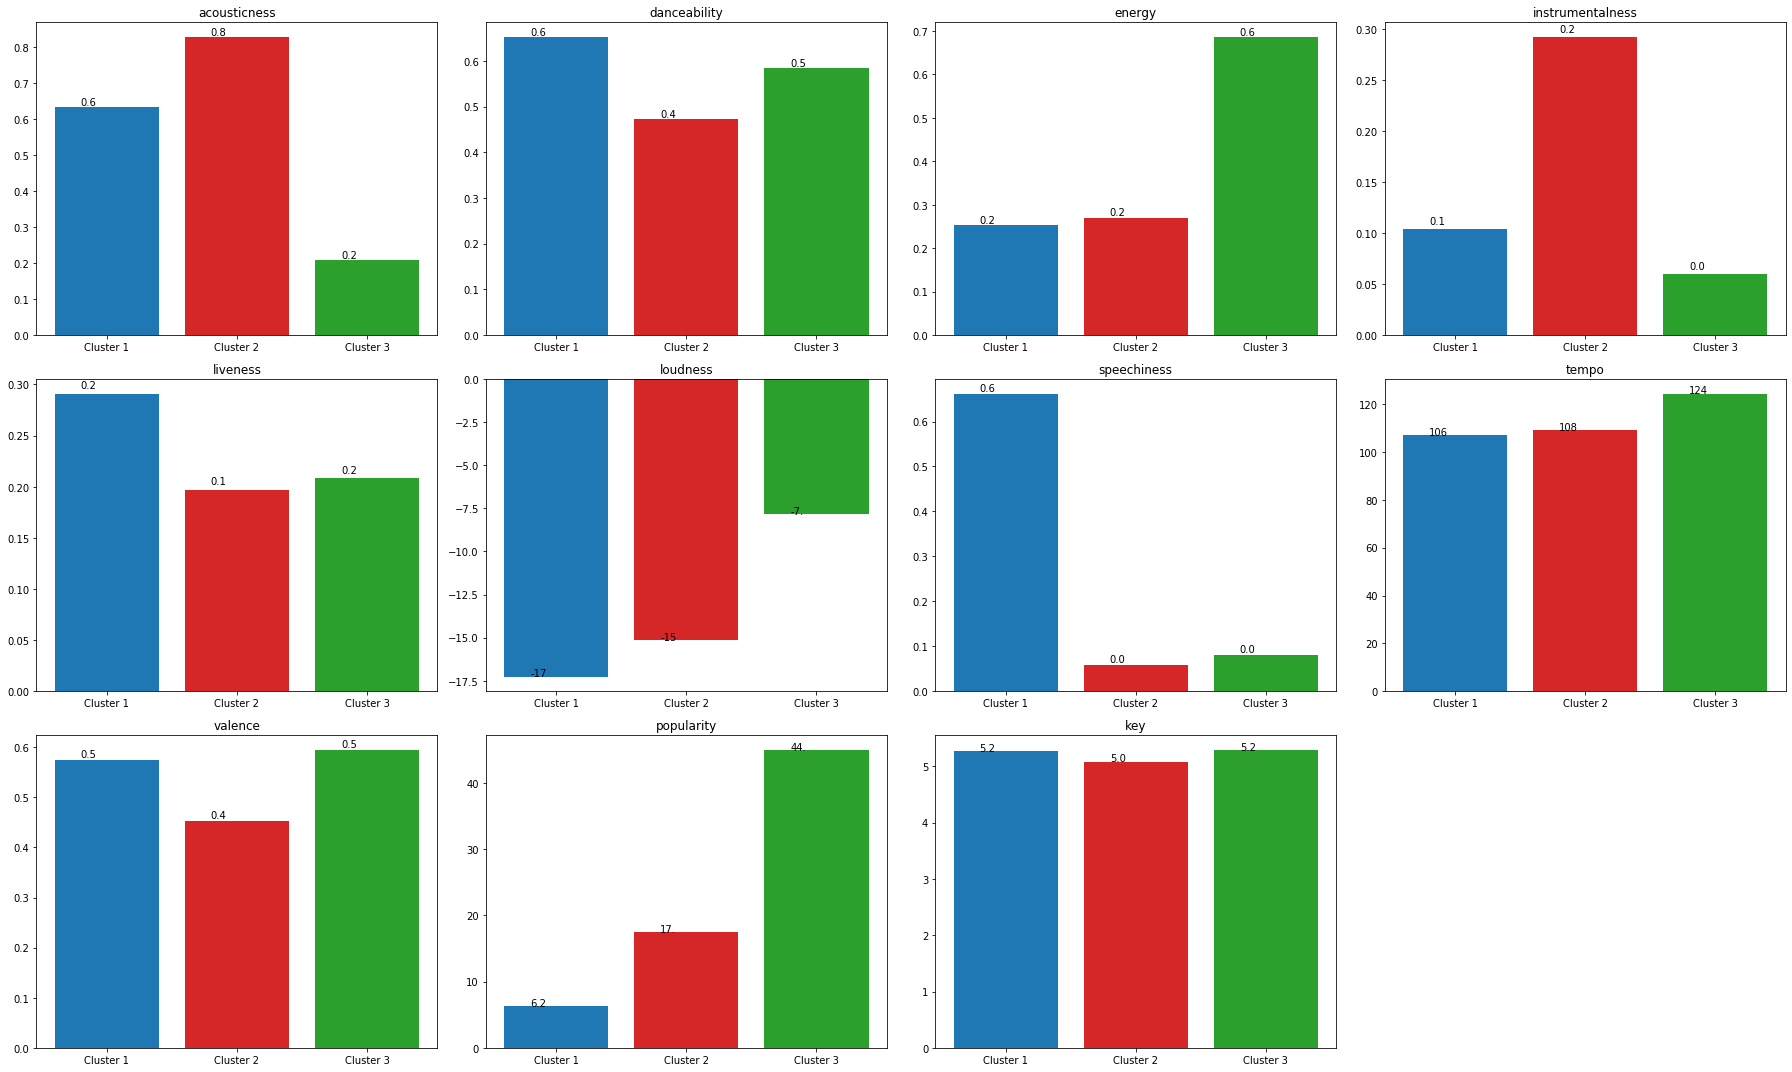

In [ ]:
clusters = ['Cluster 1','Cluster 2','Cluster 3'] 

features = ['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','popularity','key']

plt.rcParams['figure.figsize'] = [25,15]

#plot a bar graph for each feature that shows the mean value of each cluster
for i in np.arange(0,11):
  plt.subplot(3,4,i+1)
  plt.title(features[i])
  plt.bar(clusters,df_means_by_cluster[features[i]],color = ['tab:blue','tab:red','tab:green'])

  #add labels to each bar
  for n in np.arange(0,3):
    y_val = df_means_by_cluster.loc[clusters[n],features[i]]
    plt.text(x=n-.2,y=(y_val+.005),s=str(y_val)[0:3])    
  
plt.tight_layout()
plt.show()

# Apply t-SNE to the data
Next I apply the t-SNE transformation to the data. I run multiple iterations, tuning the hyperparameters each time. To run these iterations faster, and to visualize the clusters more clearly, I take a random subset with 40,000 of the total observations, or roughly 25%.

The third iteration with perpexity = 20 and verbose = .5 produced the tightest clusters and clearest boundaries. So I will apply t-SNE to the full dataset using these hyperparameters then run the KMeans algorithm again.

[t-SNE] Computing 301 nearest neighbors...
[t-SNE] Indexed 169909 samples in 0.360s...
[t-SNE] Computed neighbors for 169909 samples in 1099.634s...
[t-SNE] KL divergence after 50 iterations with early exaggeration: 110.290947
[t-SNE] KL divergence after 300 iterations: 4.412766


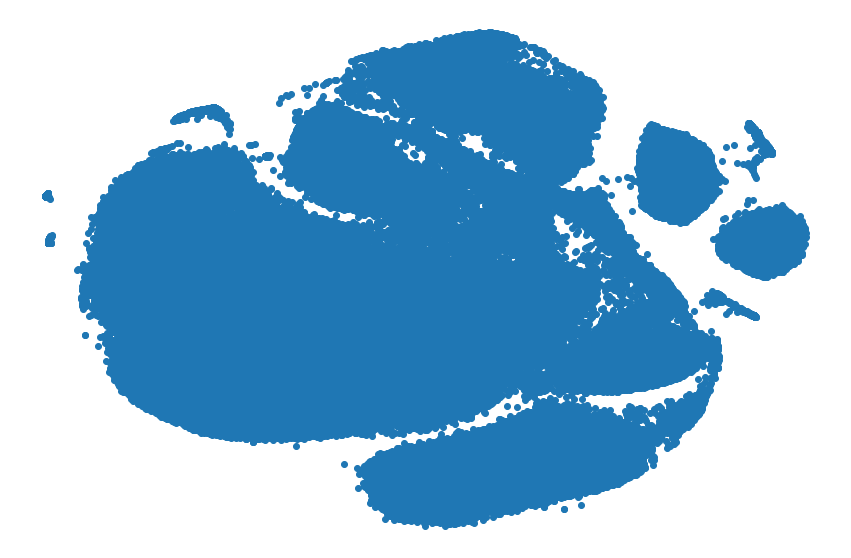

In [ ]:
#Apply the t-SNE transformation with the optimal hyperparameters
tsne = TSNE(n_components=2,verbose=.5, perplexity=100,n_iter=300, random_state = 42)
tsne_results = tsne.fit_transform(df_std)
plt.figure(figsize=(15,10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

In [ ]:
#create empty dataframe
df_tsne = pd.DataFrame()

#add the tsne results to the empty dataframe
df_tsne['column1'] = tsne_results[:,0]
df_tsne['column2'] = tsne_results[:,1]

#preview the dataframe
df_tsne.head()

column1    column2
0   4.138696   6.359632
1   0.373540  11.117936
2  10.001727  -1.732919
3   4.600275   3.586838
4   1.996475  11.986791

# Implement the KMeans Model using the t-SNE Results

In [ ]:
start_time = time.time()

#run kmeans algorithm with a range of values for the n_clusters hyperparameter
for i in np.arange(2,10):
  kmeans = KMeans(n_clusters = i, random_state=42)
  kmeans.fit(tsne_results)
  y_pred = kmeans.predict(tsne_results)

  #For each loop, print the silhouette score
  sil_score = metrics.silhouette_score(tsne_results,y_pred)
  print(f'The silhouette score for K-Means with {i} clusters is {sil_score}')

print("runtime:%s seconds" % (time.time() - start_time))

In [ ]:
#Run kmeans with the optimal number of clusters
kmeans = KMeans(n_clusters = 6, random_state=42)
kmeans.fit(tsne_results)
y_pred = kmeans.predict(tsne_results)

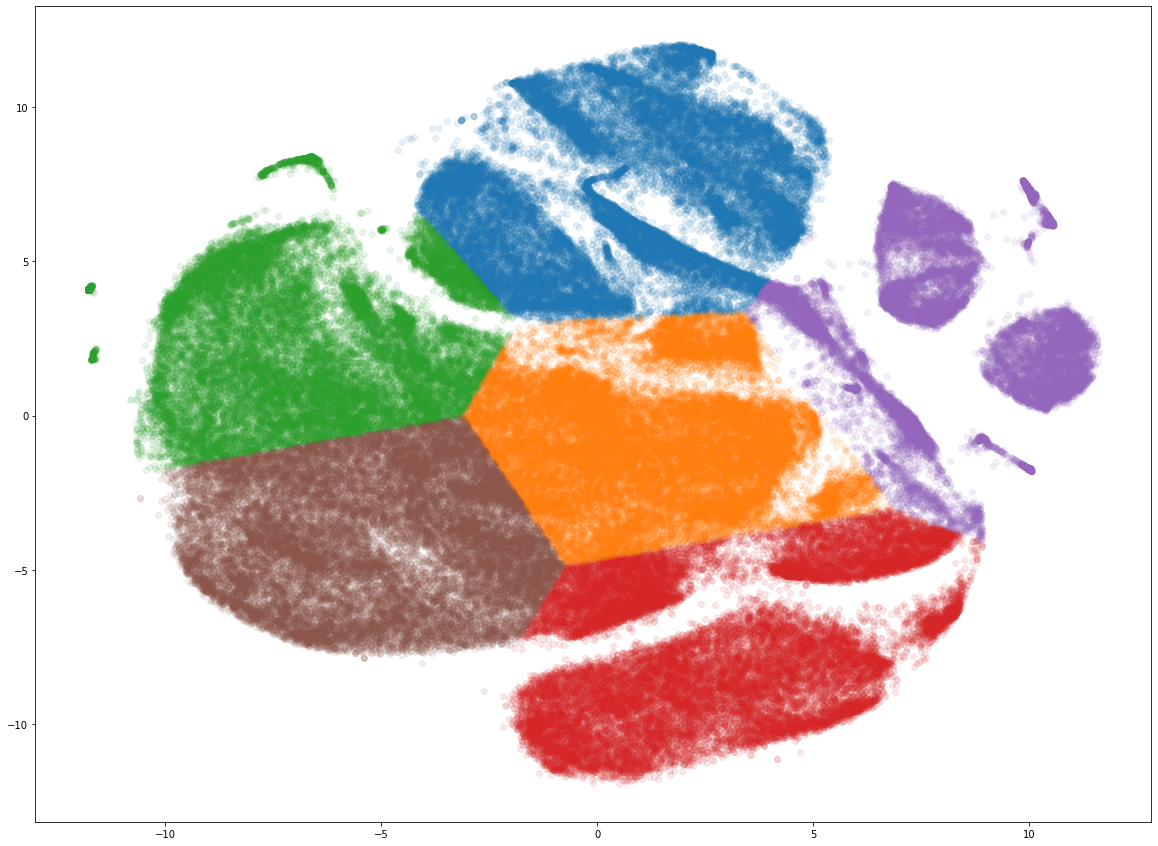

In [ ]:
#create a copy of the tsne dataframe and add a feature for the cluster identified by the kmeans algorithm
df_tsne_clusters = df_tsne.copy()
df_tsne_clusters['cluster'] = y_pred

#create sub dataframes for each cluster
df_tsne_clust1 = df_tsne_clusters[df_tsne_clusters['cluster']==0]
df_tsne_clust2 = df_tsne_clusters[df_tsne_clusters['cluster']==1]
df_tsne_clust3 = df_tsne_clusters[df_tsne_clusters['cluster']==2]
df_tsne_clust4 = df_tsne_clusters[df_tsne_clusters['cluster']==3]
df_tsne_clust5 = df_tsne_clusters[df_tsne_clusters['cluster']==4]
df_tsne_clust6 = df_tsne_clusters[df_tsne_clusters['cluster']==5]

plt.figure(figsize=(20,15))

#plot the six clusters as six different colors
plt.scatter(df_tsne_clust1['column1'],df_tsne_clust1['column2'],c='Tab:Blue', alpha=.1)
plt.scatter(df_tsne_clust2['column1'],df_tsne_clust2['column2'],c='Tab:Red', alpha=.1)
plt.scatter(df_tsne_clust3['column1'],df_tsne_clust3['column2'],c='Tab:Purple', alpha=.1)
plt.scatter(df_tsne_clust4['column1'],df_tsne_clust4['column2'],c='Tab:Green', alpha=.1)
plt.scatter(df_tsne_clust5['column1'],df_tsne_clust5['column2'],c='Tab:Orange', alpha=.1)
plt.scatter(df_tsne_clust6['column1'],df_tsne_clust6['column2'],c='Tab:Brown', alpha=.1)

In [ ]:
df_spotify_iter4 = df_spotify.copy()

#Add the KMeans cluster results as a new feature to the original spotify dataframe
df_spotify_iter4['cluster'] = y_pred

#Create a separate dataframe for each cluster
clust_1_iter4 = df_spotify_iter4[df_spotify_iter4['cluster']==0]
clust_2_iter4 = df_spotify_iter4[df_spotify_iter4['cluster']==1]
clust_3_iter4 = df_spotify_iter4[df_spotify_iter4['cluster']==2]
clust_4_iter4 = df_spotify_iter4[df_spotify_iter4['cluster']==3]
clust_5_iter4 = df_spotify_iter4[df_spotify_iter4['cluster']==4]
clust_6_iter4 = df_spotify_iter4[df_spotify_iter4['cluster']==5]

#Create a series for each cluster with the means for each feature
clust1_means = clust_1_iter4.mean()
clust2_means = clust_2_iter4.mean()
clust3_means = clust_3_iter4.mean()
clust4_means = clust_4_iter4.mean()
clust5_means = clust_5_iter4.mean()
clust6_means = clust_6_iter4.mean()

#Create dataframe with clusters as index and nunerical features as columns
df_means_by_cluster = pd.DataFrame([clust1_means,clust2_means,clust3_means,clust4_means,clust5_means,clust6_means],index=['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6'],columns=clust1_means.index)
df_means_by_cluster.head()

acousticness  danceability    duration_ms    energy  explicit  \
Cluster 1      0.880589      0.420604  248925.763405  0.231332  0.000160   
Cluster 2      0.237757      0.605399  240488.532734  0.674206  0.000000   
Cluster 3      0.306460      0.626507  229805.594855  0.595560  0.660767   
Cluster 4      0.771775      0.462363  229877.087153  0.259064  0.027066   
Cluster 5      0.206856      0.565385  229503.408145  0.699171  0.000000   

           instrumentalness       key  liveness   loudness      mode  \
Cluster 1          0.564061  5.002202  0.175886 -17.045467  0.531469   
Cluster 2          0.021886  4.961378  0.292993  -8.457540  0.373672   
Cluster 3          0.220270  5.336912  0.264509  -9.558629  0.454471   
Cluster 4          0.032713  5.789751  0.168588 -14.468710  0.893721   
Cluster 5          0.101051  6.179781  0.176088  -8.231330  0.967412   

           popularity  speechiness       tempo   valence         year  cluster  
Cluster 1   15.685082     0.056368  107.356211  0.381161  1958.234425      0.0  
Cluster 2   41.997024     0.075632  119.917535  0.648723  1989.348906      1.0  
Cluster 3   39.815900     0.235571  118.338840  0.531643  1989.064945      2.0  
Cluster 4   22.304222     0.119476  112.098544  0.386205  1965.520137      3.0  
Cluster 5   41.077965     0.067445  132.746748  0.670633  1988.729024      4.0

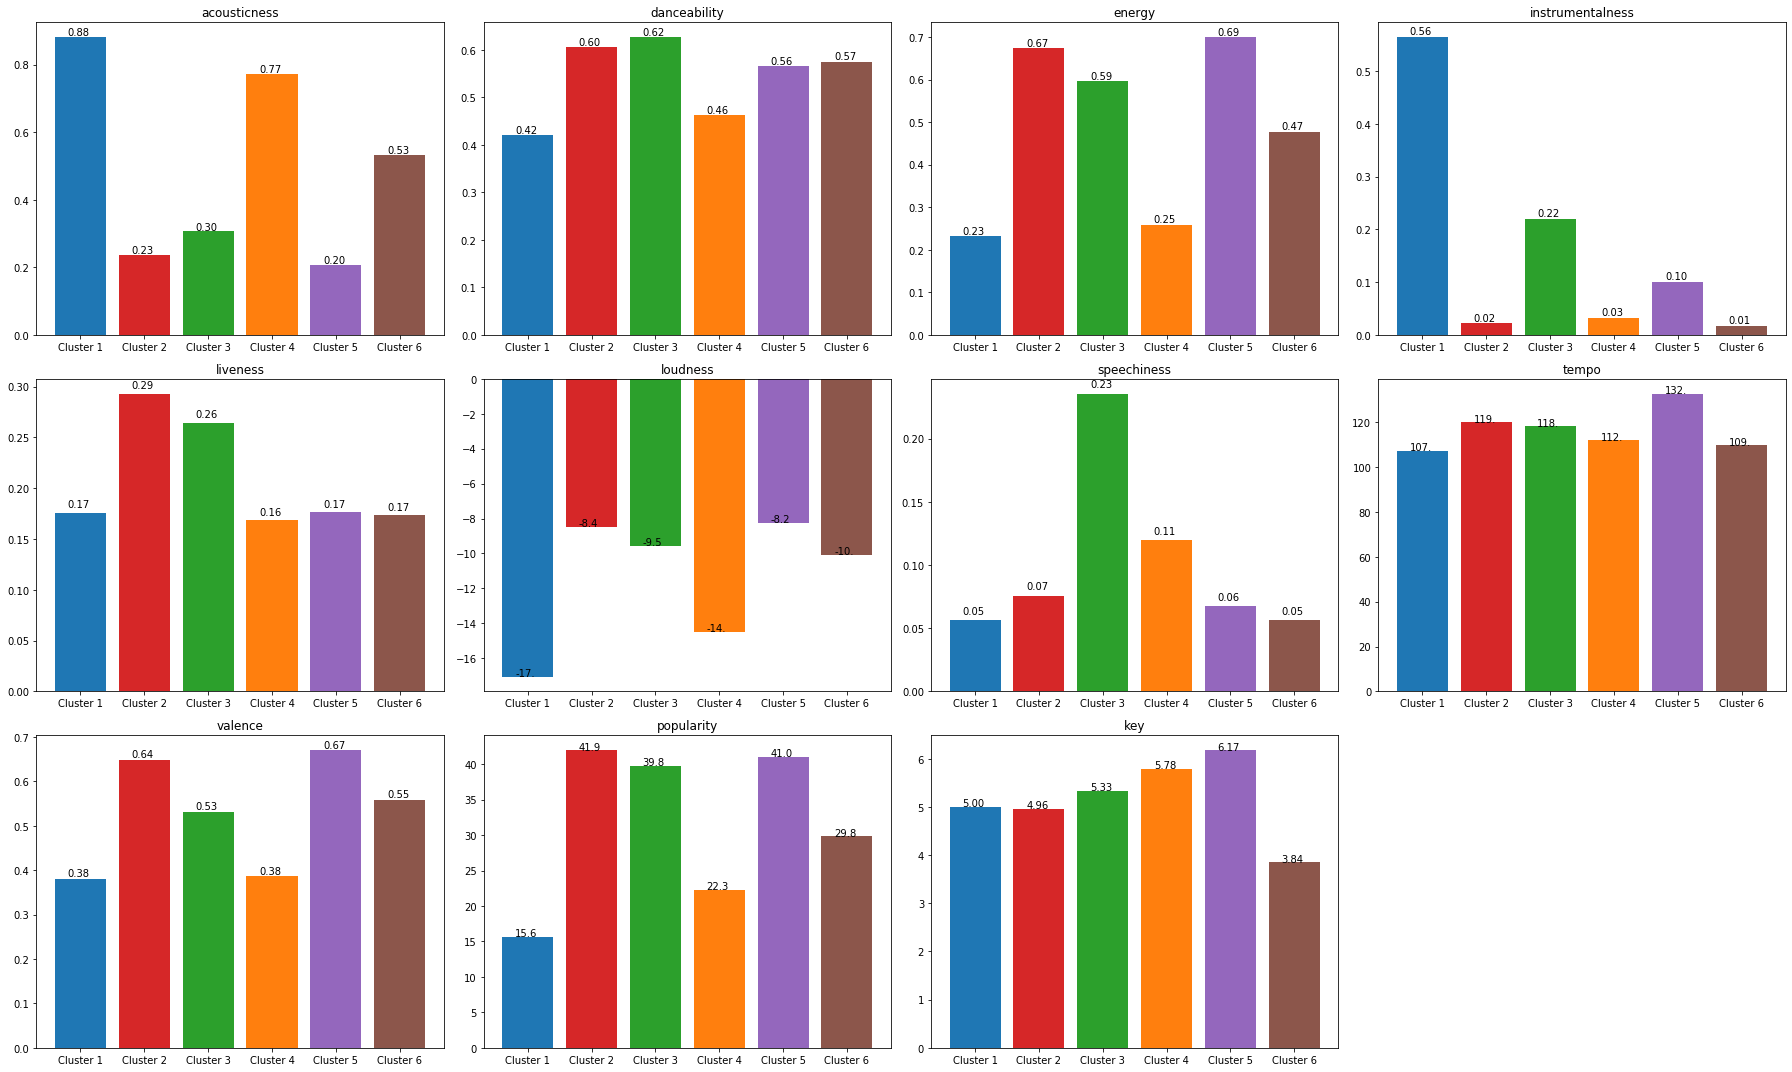

In [ ]:
clusters = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6'] 

features = ['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','popularity','key']

plt.rcParams['figure.figsize'] = [25,15]

#plot a bar graph for each feature that shows the mean value of each cluster
for i in np.arange(0,11):
  plt.subplot(3,4,i+1)
  plt.title(features[i])
  plt.bar(clusters,df_means_by_cluster[features[i]],color = ['tab:blue','tab:red','tab:green','tab:orange','tab:purple','tab:brown'])

  #add labels to each bar
  for n in np.arange(0,6):
    y_val = df_means_by_cluster.loc[clusters[n],features[i]]
    plt.text(x=n-.2,y=(y_val+.005),s=str(y_val)[0:4])    
  
plt.tight_layout()
plt.show()

In [ ]:
#Run kmeans with the optimal number of clusters
kmeans = KMeans(n_clusters = 9, random_state=42)
kmeans.fit(tsne_results)
y_pred = kmeans.predict(tsne_results)

sil_score = metrics.silhouette_score(tsne_results,y_pred)
print(f'The silhouette score for K-Means with 9 clusters is {sil_score}')

The silhouette score for K-Means with 9 clusters is 0.3822234570980072


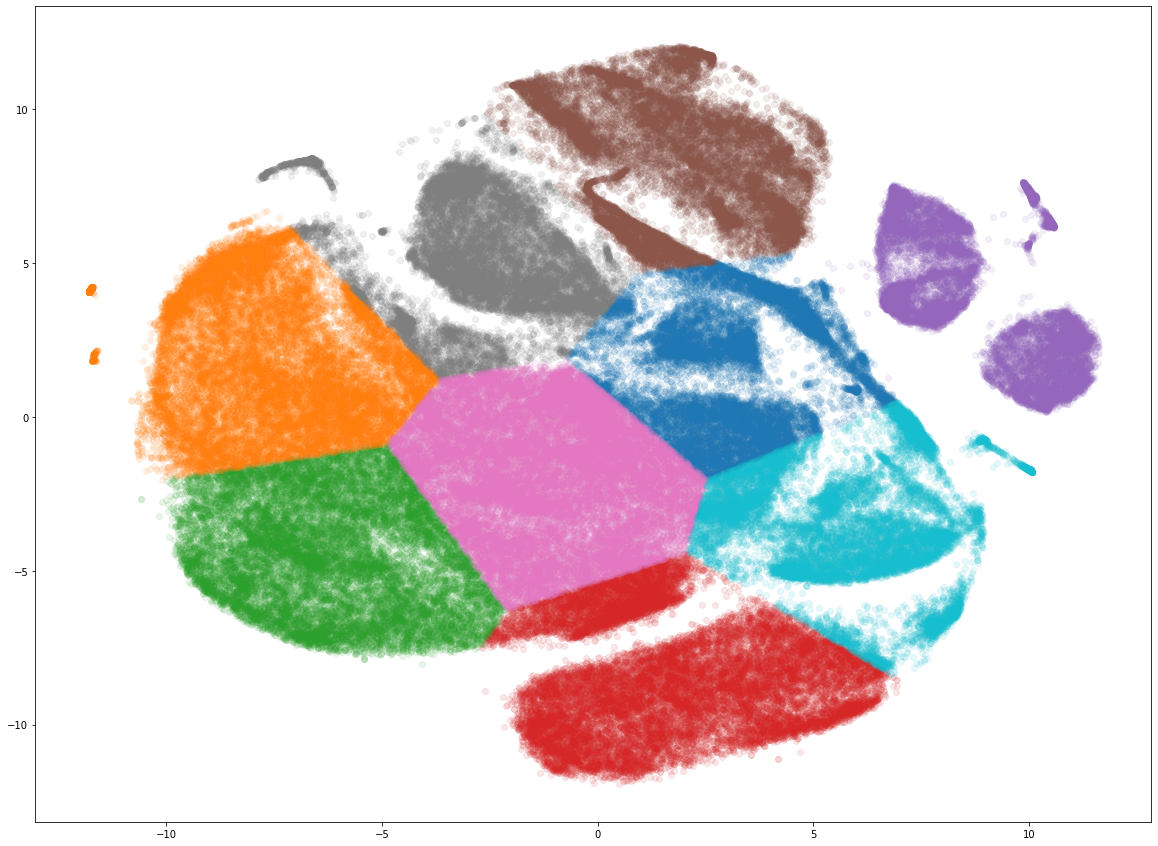

In [ ]:
#create a copy of the tsne dataframe and add a feature for the cluster identified by the kmeans algorithm
df_tsne_clusters = df_tsne.copy()
df_tsne_clusters['cluster'] = y_pred

#create sub dataframes for each cluster
df_tsne_clust1 = df_tsne_clusters[df_tsne_clusters['cluster']==0]
df_tsne_clust2 = df_tsne_clusters[df_tsne_clusters['cluster']==1]
df_tsne_clust3 = df_tsne_clusters[df_tsne_clusters['cluster']==2]
df_tsne_clust4 = df_tsne_clusters[df_tsne_clusters['cluster']==3]
df_tsne_clust5 = df_tsne_clusters[df_tsne_clusters['cluster']==4]
df_tsne_clust6 = df_tsne_clusters[df_tsne_clusters['cluster']==5]
df_tsne_clust7 = df_tsne_clusters[df_tsne_clusters['cluster']==6]
df_tsne_clust8 = df_tsne_clusters[df_tsne_clusters['cluster']==7]
df_tsne_clust9 = df_tsne_clusters[df_tsne_clusters['cluster']==8]


plt.figure(figsize=(20,15))

#plot the six clusters as six different colors
plt.scatter(df_tsne_clust1['column1'],df_tsne_clust1['column2'],c='Tab:Blue', alpha=.1)
plt.scatter(df_tsne_clust2['column1'],df_tsne_clust2['column2'],c='Tab:Red', alpha=.1)
plt.scatter(df_tsne_clust3['column1'],df_tsne_clust3['column2'],c='Tab:Purple', alpha=.1)
plt.scatter(df_tsne_clust4['column1'],df_tsne_clust4['column2'],c='Tab:Green', alpha=.1)
plt.scatter(df_tsne_clust5['column1'],df_tsne_clust5['column2'],c='Tab:Orange', alpha=.1)
plt.scatter(df_tsne_clust6['column1'],df_tsne_clust6['column2'],c='Tab:Brown', alpha=.1)
plt.scatter(df_tsne_clust7['column1'],df_tsne_clust7['column2'],c='Tab:Gray', alpha=.1)
plt.scatter(df_tsne_clust8['column1'],df_tsne_clust8['column2'],c='Tab:Pink', alpha=.1)
plt.scatter(df_tsne_clust9['column1'],df_tsne_clust9['column2'],c='Tab:Cyan', alpha=.1)

# Run the DBSCAN Model using the t-SNE results as inputs

In [ ]:
start_time = time.time()

#Set the range of values to try for eps
eps_vals = [.1,.2,.5,1]

#Set the range of values to try for min_samples
min_samples_vals = [1,5,10,20]

#Run a loop of DBSCAN models, trying a different value for the eps and min_samples hyperparameters each time
for i in eps_vals:
    for n in min_samples_vals:
        dbscan = DBSCAN(eps=i, min_samples = n, metric='euclidean')
        y_pred = dbscan.fit_predict(tsne_results)

        #For each loop, print the number of clusters
        count_clusters = len(np.unique(y_pred))
        print(f'Number of clusters when eps = {i} & min_samples = {n}: {count_clusters}')

        #For each loop, print the silhouette score
        sil_score = metrics.silhouette_score(tsne_results,y_pred)
        print(f'   The silhouette score with eps = {i} & min_samples = {n}: {sil_score}')

print("runtime:%s seconds" % (time.time() - start_time))

NameError: ignored

In [ ]:
dbscan = DBSCAN(eps=.8, min_samples = 10, metric='euclidean')
y_pred = dbscan.fit_predict(tsne_results)

#For each loop, print the number of clusters
count_clusters = len(np.unique(y_pred))
print(f'Number of clusters when eps = .8 & min_samples = 10: {count_clusters}')

#For each loop, print the silhouette score
sil_score = metrics.silhouette_score(tsne_results,y_pred)
print(f'   The silhouette score with eps = .8 & min_samples = 10: {sil_score}')

In [ ]:
np.unique(y_pred, return_counts=True)

In [ ]:
#Set the 'cluster' feature in the t-SNE dataframe equal to the new clusters from the DBSCAN Model
df_tsne_clusters['cluster'] = y_pred

#create sub dataframes for each cluster
df_tsne_clust1 = df_tsne_clusters[df_tsne_clusters['cluster']==0]
df_tsne_clust2 = df_tsne_clusters[df_tsne_clusters['cluster']==1]
df_tsne_clust3 = df_tsne_clusters[df_tsne_clusters['cluster']==2]
df_tsne_clust4 = df_tsne_clusters[df_tsne_clusters['cluster']==3]

plt.figure(figsize=(20,15))

#plot the 3 clusters as 3 different colors
plt.scatter(df_tsne_clust1['column1'],df_tsne_clust1['column2'],c='Tab:Red', alpha=.1)
plt.scatter(df_tsne_clust2['column1'],df_tsne_clust2['column2'],c='Tab:Blue', alpha=.1)
plt.scatter(df_tsne_clust3['column1'],df_tsne_clust3['column2'],c='Tab:Green', alpha=.1)
plt.scatter(df_tsne_clust4['column1'],df_tsne_clust4['column2'],c='Tab:Orange', alpha=.1)

In [ ]:
dbscan = DBSCAN(eps=.6, min_samples = 50, metric='euclidean')
y_pred = dbscan.fit_predict(tsne_results)

#For each loop, print the number of clusters
count_clusters = len(np.unique(y_pred))
print(f'Number of clusters when eps = .6 & min_samples = 50: {count_clusters}')

#For each loop, print the silhouette score
sil_score = metrics.silhouette_score(tsne_results,y_pred)
print(f'   The silhouette score with eps = .6 & min_samples = 50: {sil_score}')

In [ ]:
#Set the 'cluster' feature in the t-SNE dataframe equal to the new clusters from the DBSCAN Model
df_tsne_clusters['cluster'] = y_pred

#create sub dataframes for each cluster
df_tsne_clust1 = df_tsne_clusters[df_tsne_clusters['cluster']==0]
df_tsne_clust2 = df_tsne_clusters[df_tsne_clusters['cluster']==1]
df_tsne_clust3 = df_tsne_clusters[df_tsne_clusters['cluster']==2]
df_tsne_clust4 = df_tsne_clusters[df_tsne_clusters['cluster']==3]
df_tsne_clust5 = df_tsne_clusters[df_tsne_clusters['cluster']==4]
df_tsne_clust6 = df_tsne_clusters[df_tsne_clusters['cluster']==5]

plt.figure(figsize=(20,15))

#plot the 3 clusters as 3 different colors
plt.scatter(df_tsne_clust1['column1'],df_tsne_clust1['column2'],c='Tab:Red', alpha=.1)
plt.scatter(df_tsne_clust2['column1'],df_tsne_clust2['column2'],c='Tab:Blue', alpha=.1)
plt.scatter(df_tsne_clust3['column1'],df_tsne_clust3['column2'],c='Tab:Green', alpha=.1)
plt.scatter(df_tsne_clust4['column1'],df_tsne_clust4['column2'],c='Tab:Orange', alpha=.1)
plt.scatter(df_tsne_clust5['column1'],df_tsne_clust5['column2'],c='Tab:Orange', alpha=.1)
plt.scatter(df_tsne_clust6['column1'],df_tsne_clust6['column2'],c='Tab:Brown', alpha=.1)

In [ ]:
df_spotify_iter5 = df_spotify.copy()

#Add the KMeans cluster results as a new feature to the original spotify dataframe
df_spotify_iter5['cluster'] = y_pred

#Create a separate dataframe for each cluster
clust_1_iter5 = df_spotify_iter5[df_spotify_iter5['cluster']==0]
clust_2_iter5 = df_spotify_iter5[df_spotify_iter5['cluster']==1]
clust_3_iter5 = df_spotify_iter5[df_spotify_iter5['cluster']==2]
clust_4_iter5 = df_spotify_iter5[df_spotify_iter5['cluster']==3]
clust_5_iter5 = df_spotify_iter5[df_spotify_iter5['cluster']==4]
clust_6_iter5 = df_spotify_iter5[df_spotify_iter5['cluster']==5]

#Create a series for each cluster with the means for each feature
clust1_means = clust_1_iter5.mean()
clust2_means = clust_2_iter5.mean()
clust3_means = clust_3_iter5.mean()
clust4_means = clust_4_iter5.mean()
clust5_means = clust_5_iter5.mean()
clust6_means = clust_6_iter5.mean()

#Create dataframe with clusters as index and nunerical features as columns
df_means_by_cluster = pd.DataFrame([clust1_means,clust2_means,clust3_means,clust4_means,clust5_means,clust6_means],index=['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6'],columns=clust1_means.index)
df_means_by_cluster.head()

In [ ]:
#Check the number of observations in each cluster
np.unique(y_pred,return_counts=True)

In [ ]:
#Check the number of observations in each cluster
np.unique(y_pred,return_counts=True)

In [ ]:
clusters = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6'] 

features = ['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','popularity','key']

plt.rcParams['figure.figsize'] = [25,15]

#plot a bar graph for each feature that shows the mean value of each cluster
for i in np.arange(0,11):
  plt.subplot(3,4,i+1)
  plt.title(features[i])
  plt.bar(clusters,df_means_by_cluster[features[i]],color = ['tab:blue','tab:red','tab:green','tab:orange','tab:purple','tab:brown'])

  #add labels to each bar
  for n in np.arange(0,6):
    y_val = df_means_by_cluster.loc[clusters[n],features[i]]
    plt.text(x=n-.2,y=(y_val+.005),s=str(y_val)[0:4])    
  
plt.tight_layout()
plt.show()

# Run the GMM Model using the t-SNE Results as inputs

In [ ]:
from sklearn.mixture import GaussianMixture

start_time = time.time()

#run GMM algorithm with a range of values for the n_clusters
for i in np.arange(2,10):
  gmm = GaussianMixture(n_components = i, random_state=42)
  y_pred = gmm.fit_predict(tsne_results)
    
  #For each loop, print the silhouette score
  sil_score = metrics.silhouette_score(tsne_results,y_pred)
  print(f'The silhouette score for GMM with {i} clusters is {sil_score}')

print("runtime:%s seconds" % (time.time() - start_time))

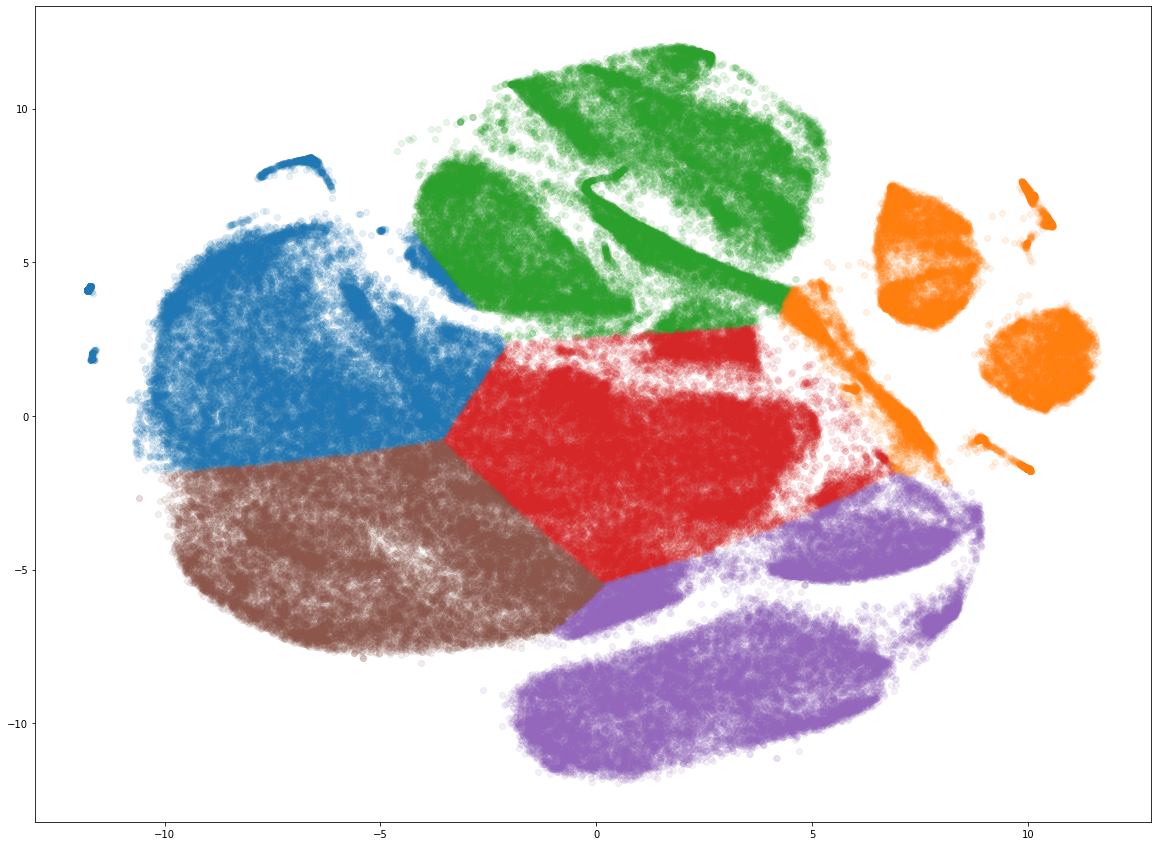

In [ ]:
#Run the GMM model with the optimal hyperparameters and store the clusters as variable 'y_pred'
gmm = GaussianMixture(n_components = 6, random_state=42)
y_pred = gmm.fit_predict(tsne_results)

#Set the 'cluster' feature in the t-SNE dataframe equal to the new clusters from the DBSCAN Model
df_tsne_clusters['cluster'] = y_pred

#create sub dataframes for each cluster
df_tsne_clust1 = df_tsne_clusters[df_tsne_clusters['cluster']==0]
df_tsne_clust2 = df_tsne_clusters[df_tsne_clusters['cluster']==1]
df_tsne_clust3 = df_tsne_clusters[df_tsne_clusters['cluster']==2]
df_tsne_clust4 = df_tsne_clusters[df_tsne_clusters['cluster']==3]
df_tsne_clust5 = df_tsne_clusters[df_tsne_clusters['cluster']==4]
df_tsne_clust6 = df_tsne_clusters[df_tsne_clusters['cluster']==5]

plt.figure(figsize=(20,15))

#plot the 3 clusters as 3 different colors
plt.scatter(df_tsne_clust1['column1'],df_tsne_clust1['column2'],c='Tab:Red', alpha=.1)
plt.scatter(df_tsne_clust2['column1'],df_tsne_clust2['column2'],c='Tab:Blue', alpha=.1)
plt.scatter(df_tsne_clust3['column1'],df_tsne_clust3['column2'],c='Tab:Green', alpha=.1)
plt.scatter(df_tsne_clust4['column1'],df_tsne_clust4['column2'],c='Tab:Purple', alpha=.1)
plt.scatter(df_tsne_clust5['column1'],df_tsne_clust5['column2'],c='Tab:Orange', alpha=.1)
plt.scatter(df_tsne_clust6['column1'],df_tsne_clust6['column2'],c='Tab:Brown', alpha=.1)

In [ ]:
df_spotify_iter6 = df_spotify.copy()

#Add the GMM cluster results as a new feature to the original spotify dataframe
df_spotify_iter6['cluster'] = y_pred

#Create a separate dataframe for each cluster
clust_1_iter6 = df_spotify_iter6[df_spotify_iter6['cluster']==0]
clust_2_iter6 = df_spotify_iter6[df_spotify_iter6['cluster']==1]
clust_3_iter6 = df_spotify_iter6[df_spotify_iter6['cluster']==2]
clust_4_iter6 = df_spotify_iter6[df_spotify_iter6['cluster']==3]
clust_5_iter6 = df_spotify_iter6[df_spotify_iter6['cluster']==4]
clust_6_iter6 = df_spotify_iter6[df_spotify_iter6['cluster']==5]

#Create a series for each cluster with the means for each feature
clust1_means = clust_1_iter6.mean()
clust2_means = clust_2_iter6.mean()
clust3_means = clust_3_iter6.mean()
clust4_means = clust_4_iter6.mean()
clust5_means = clust_5_iter6.mean()
clust6_means = clust_6_iter6.mean()

#Create dataframe with clusters as index and nunerical features as columns
df_means_by_cluster = pd.DataFrame([clust1_means,clust2_means,clust3_means,clust4_means,clust5_means,clust6_means],index=['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6'],columns=clust1_means.index)
df_means_by_cluster.head()

acousticness  danceability    duration_ms    energy  explicit  \
Cluster 1      0.200988      0.567033  229704.766461  0.705057  0.000000   
Cluster 2      0.754203      0.461526  232133.733459  0.261652  0.026622   
Cluster 3      0.871112      0.432231  244743.105841  0.242269  0.000147   
Cluster 4      0.242496      0.594345  248429.271415  0.669728  0.000000   
Cluster 5      0.277977      0.639692  222181.873328  0.605822  0.719385   

           instrumentalness       key  liveness   loudness      mode  \
Cluster 1          0.084982  6.103692  0.177699  -8.099080  0.973102   
Cluster 2          0.030550  5.746734  0.165923 -14.395778  0.938379   
Cluster 3          0.551275  5.059265  0.176018 -16.707837  0.512689   
Cluster 4          0.029687  5.273030  0.314915  -8.548992  0.319359   
Cluster 5          0.196879  5.347531  0.244970  -9.277933  0.468411   

           popularity  speechiness       tempo   valence         year  cluster  
Cluster 1   41.544705     0.066382  132.506474  0.670028  1989.245976      0.0  
Cluster 2   24.169353     0.116411  112.161405  0.372390  1967.557823      1.0  
Cluster 3   15.393364     0.057600  107.587514  0.402382  1957.932285      2.0  
Cluster 4   41.630846     0.078422  120.615409  0.627822  1989.095350      3.0  
Cluster 5   41.636306     0.248286  118.268446  0.527727  1991.366905      4.0

In [ ]:
#Check the number of observations in each cluster
np.unique(y_pred, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([33609, 28172, 33966, 29722, 18994, 25446]))

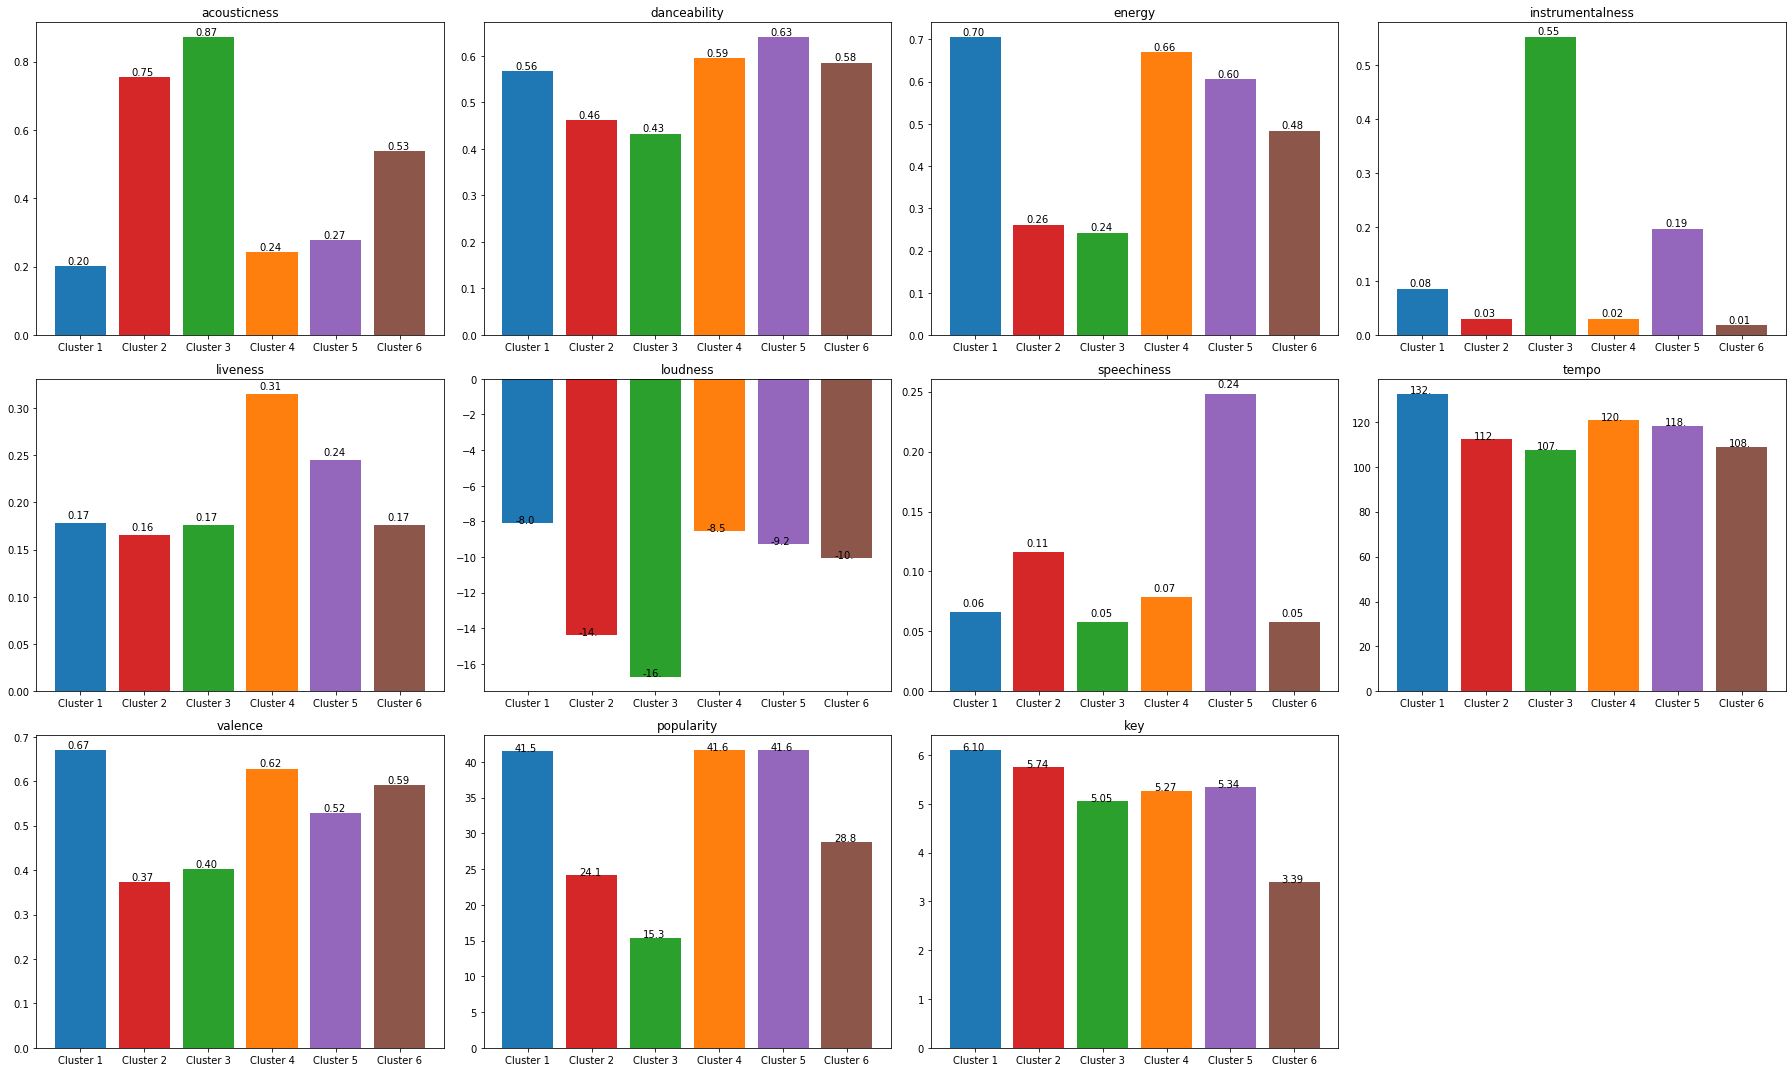

In [ ]:
clusters = ['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6'] 

features = ['acousticness','danceability','energy','instrumentalness','liveness','loudness','speechiness','tempo','valence','popularity','key']

plt.rcParams['figure.figsize'] = [25,15]

#plot a bar graph for each feature that shows the mean value of each cluster
for i in np.arange(0,11):
  plt.subplot(3,4,i+1)
  plt.title(features[i])
  plt.bar(clusters,df_means_by_cluster[features[i]],color = ['tab:blue','tab:red','tab:green','tab:orange','tab:purple','tab:brown'])

  #add labels to each bar
  for n in np.arange(0,6):
    y_val = df_means_by_cluster.loc[clusters[n],features[i]]
    plt.text(x=n-.2,y=(y_val+.005),s=str(y_val)[0:4])    
  
plt.tight_layout()
plt.show()

In [ ]:
import time
start_time = time.time()

#Run the GMM model with the optimal hyperparameters and store the clusters as variable 'y_pred'
gmm = GaussianMixture(n_components = 6, random_state=42)
y_pred = gmm.fit_predict(tsne_results)

print("runtime:%s seconds" % (time.time() - start_time))

runtime:1.8721978664398193 seconds


In [ ]:
start_time = time.time()

#Run kmeans with the optimal number of clusters
kmeans = KMeans(n_clusters = 6, random_state=42)
kmeans.fit(tsne_results)
y_pred = kmeans.predict(tsne_results)

print("runtime:%s seconds" % (time.time() - start_time))

runtime:4.290918827056885 seconds


# Digging into the Clusters: PCA + K-Means
4 Clusters

In [ ]:
top_50_artists = df_spotify['artists'].value_counts(ascending=False).index[:50]

#Remove the top 50 artists from the dataframe for analysis
iter1_reduced = df_spotify_iter1[~df_spotify_iter1['artists'].isin(top_50_artists)]

#Check to make sure the top artists don't appear
iter1_reduced['artists'].value_counts(ascending=False).index[:20]

Index(['['Willie Nelson']', '['Billy Joel']', '['KISS']',
       '['Waylon Jennings']', '['Duke Ellington']', '['Taylor Swift']',
       '['Sam Cooke']', '['Van Morrison']', '['Talking Heads']',
       '['Nat King Cole']', '['Eminem']',
       '['Francisco Canaro', 'Roberto Maida']', '['Jimmy Buffett']',
       '['Sarah Vaughan']', '['The Cure']',
       '['Frédéric Chopin', 'Vladimir Horowitz']', '['Charles Mingus']',
       '['Michael Jackson']', '['Genesis']',
       '['Igor Stravinsky', 'Columbia Symphony Orchestra']'],
      dtype='object')

In [ ]:
clust1_artists = iter1_reduced[iter1_reduced['cluster']==0]['artists'].value_counts(ascending=False).to_frame()

clust1_years = iter1_reduced[iter1_reduced['cluster']==0]['year'].value_counts(ascending=False).to_frame()

clust1_artists.head(20)

artists
['Dale Carnegie', 'Till Hagen', 'Stefan Kaminski']      128
['Ernst H. Gombrich', 'Christoph Waltz']                109
['Zofia Dromlewiczowa']                                  96
['Patricia St. John']                                    83
['Seweryn Goszczyński']                                  76
['Federico García Lorca']                                44
['Tom Lehrer']                                           40
['Robin Williams']                                       38
['Bill Cosby']                                           38
['Alcoholics Anonymous']                                 36
['Shamshad Begum']                                       31
['Honoré de Balzac']                                     30
['Manfried Rössner']                                     29
['Carmen Miranda']                                       23
['Deutsche Grammophon Literatur', 'Johann Wolfg...       21
['Asha Bhosle']                                          20
['Robert Frost']                                         19
['Harold Courlander']                                    16
['Geeta Dutt']                                           15
['Amirbai Karnataki']                                    15

In [ ]:
clust1_years.head(20)

year
1952   207
1936   186
1954   153
1949   136
1955   131
1951   122
1931   120
1947   101
1944    99
1953    98
1948    93
1945    91
1946    85
1928    81
1950    69
1939    69
1942    62
1941    56
1932    50
1959    49

In [ ]:
clust2_artists = iter1_reduced[iter1_reduced['cluster']==1]['artists'].value_counts(ascending=False).to_frame()

clust2_years = iter1_reduced[iter1_reduced['cluster']==1]['year'].value_counts(ascending=False).to_frame()

clust2_artists.head(20)

artists
['KISS']                      182
['Eminem']                    169
['Taylor Swift']              167
['Talking Heads']             154
['Ramones']                   148
['AC/DC']                     146
['Michael Jackson']           140
['Green Day']                 135
['Nirvana']                   133
['Rush']                      130
['The Cure']                  127
['Aerosmith']                 124
['R.E.M.']                    123
['Los Tigres Del Norte']      122
['Billy Joel']                117
['BTS']                       116
['Drake']                     116
['Judas Priest']              113
['Journey']                   112
['The Smiths']                111

In [ ]:
clust2_years.head(20)

year
2018  1722
2010  1688
2019  1678
2014  1654
2009  1646
2008  1646
2012  1633
2013  1620
2005  1604
2011  1601
2015  1590
2007  1584
2016  1559
2003  1558
2006  1542
2017  1540
2004  1528
2001  1524
2002  1506
2020  1497

In [ ]:
clust3_artists = iter1_reduced[iter1_reduced['cluster']==2]['artists'].value_counts(ascending=False).to_frame()

clust3_years = iter1_reduced[iter1_reduced['cluster']==2]['year'].value_counts(ascending=False).to_frame()

clust3_artists.head(20)

artists
['Francisco Canaro', 'Roberto Maida']      168
['Willie Nelson']                          128
['Waylon Jennings']                        128
['Roza Eskenazi']                          122
['Sam Cooke']                              119
['James Taylor']                           117
['Marty Robbins']                          109
['Nat King Cole']                          108
['John Prine']                             105
['Van Morrison']                           102
['Jimmy Buffett']                          102
['Lefty Frizzell']                         100
['Otis Redding']                            95
['Peggy Lee']                               94
['John Denver']                             92
['Geeta Dutt']                              91
['Shamshad Begum']                          91
['José Alfredo Jimenez']                    89
['Rita Ampatzi']                            89
['The Moody Blues']                         89

In [ ]:
clust3_years.head(20)

year
1962  1069
1960  1002
1968   976
1950   946
1972   924
1974   920
1964   909
1961   907
1957   902
1963   890
1970   885
1956   875
1959   872
1940   853
1969   845
1930   841
1958   840
1965   838
1967   837
1971   819

In [ ]:
clust4_artists = iter1_reduced[iter1_reduced['cluster']==3]['artists'].value_counts(ascending=False).to_frame()

clust4_years = iter1_reduced[iter1_reduced['cluster']==3]['year'].value_counts(ascending=False).to_frame()

clust4_artists.head(20)

artists
['Frédéric Chopin', 'Vladimir Horowitz']                177
['Igor Stravinsky', 'Columbia Symphony Orchestra']      161
['Bill Evans Trio']                                     142
['Giuseppe Verdi', 'Arturo Toscanini']                  121
['Jackie Gleason']                                      121
['Alexander Scriabin', 'Vladimir Horowitz']             111
['Sarah Vaughan']                                       106
['Robert Schumann', 'Vladimir Horowitz']                102
['Duke Ellington']                                       89
['Franz Joseph Haydn', 'Pro Arte Quartet']               88
['John Williams', 'London Symphony Orchestra']           86
['Chet Baker']                                           85
['Ludwig van Beethoven', 'Rudolf Serkin']                85
['Doris Day']                                            84
['Frédéric Chopin', 'William Kapell']                    83
['Charles Mingus']                                       82
['John Williams']                                        80
['Julie London']                                         80
['Charlie Chaplin']                                      79
['Judy Garland']                                         77

# Digging into the Clusters: t-SNE + K-Means
6 Clusters

In [ ]:
top_50_artists = df_spotify['artists'].value_counts(ascending=False).index[:50]

#Remove the top 50 artists from the dataframe for analysis
iter4_reduced = df_spotify_iter4[~df_spotify_iter4['artists'].isin(top_50_artists)]

#Check to make sure the top artists don't appear
iter4_reduced['artists'].value_counts(ascending=False).index[:20]

Index(['['Willie Nelson']', '['Billy Joel']', '['KISS']',
       '['Waylon Jennings']', '['Duke Ellington']', '['Taylor Swift']',
       '['Sam Cooke']', '['Van Morrison']', '['Talking Heads']',
       '['Nat King Cole']', '['Eminem']',
       '['Francisco Canaro', 'Roberto Maida']', '['Jimmy Buffett']',
       '['Sarah Vaughan']', '['The Cure']',
       '['Frédéric Chopin', 'Vladimir Horowitz']', '['Charles Mingus']',
       '['Michael Jackson']', '['Genesis']',
       '['Igor Stravinsky', 'Columbia Symphony Orchestra']'],
      dtype='object')

In [ ]:
### CLUSTER 1 ###
clust1_artists = iter4_reduced[iter4_reduced['cluster']==0]['artists'].value_counts(ascending=False).to_frame()

clust1_years = iter4_reduced[iter4_reduced['cluster']==0]['year'].value_counts(ascending=False).to_frame()

clust1_artists.head(20)

artists
['Frédéric Chopin', 'Vladimir Horowitz']                167
['Igor Stravinsky', 'Columbia Symphony Orchestra']      143
['Bill Evans Trio']                                     135
['Jackie Gleason']                                      111
['Alexander Scriabin', 'Vladimir Horowitz']             104
['Robert Schumann', 'Vladimir Horowitz']                102
['John Williams', 'London Symphony Orchestra']           89
['Duke Ellington']                                       87
['Frédéric Chopin', 'William Kapell']                    83
['Ludwig van Beethoven', 'Rudolf Serkin']                82
['Charles Mingus']                                       81
['Chet Baker']                                           79
['John Williams']                                        78
['Ennio Morricone']                                      70
['Charlie Chaplin']                                      69
['Bill Evans']                                           68
['Sarah Vaughan']                                        68
['Henry Mancini']                                        67
['Percy Faith & His Orchestra']                          67
['Frédéric Chopin', 'Robert Lortat']                     67

In [ ]:
clust1_years.head(20)

year
1948   948
1949   812
1951   782
1946   774
1953   758
1942   704
1950   703
1947   695
1961   691
1952   688
1945   685
1940   683
1955   680
1954   655
1930   645
1956   597
1958   576
1960   549
1957   548
1941   518

In [ ]:
### CLUSTER 2 ###
clust2_artists = iter4_reduced[iter4_reduced['cluster']==1]['artists'].value_counts(ascending=False).to_frame()

clust2_years = iter4_reduced[iter4_reduced['cluster']==1]['year'].value_counts(ascending=False).to_frame()

clust2_artists.head(20)

artists
['Talking Heads']                 97
['Michael Jackson']               78
['KISS']                          76
['BTS']                           71
['Billy Joel']                    70
['Bruce Springsteen']             63
['Bee Gees']                      60
['Eagles']                        59
['Steely Dan']                    57
['Depeche Mode']                  57
['The Cure']                      57
['Judas Priest']                  56
['Madonna']                       54
['Prince']                        54
['Daryl Hall & John Oates']       53
['Eric Clapton']                  52
['Linkin Park']                   52
['The Clash']                     51
['Rush']                          51
['Journey']                       50

In [ ]:
clust2_years.head(20)

year
1982   664
1979   638
1981   624
1986   618
1985   611
1983   594
1984   591
2008   586
2010   566
1980   564
2007   562
2002   562
1990   557
2004   554
2003   554
2006   553
1978   552
1976   542
1977   539
1988   538

In [ ]:
### CLUSTER 3 ###
clust3_artists = iter4_reduced[iter4_reduced['cluster']==2]['artists'].value_counts(ascending=False).to_frame()

clust3_years = iter4_reduced[iter4_reduced['cluster']==2]['year'].value_counts(ascending=False).to_frame()

clust3_artists.head(20)

artists
['Eminem']                                              165
['Drake']                                               113
['2Pac']                                                 95
['Ernst H. Gombrich', 'Christoph Waltz']                 87
['Mac Miller']                                           85
['Lil Uzi Vert']                                         85
['JAY-Z']                                                84
['Dale Carnegie', 'Till Hagen', 'Stefan Kaminski']       78
['Five Finger Death Punch']                              73
['Kanye West']                                           69
['YoungBoy Never Broke Again']                           67
['The Notorious B.I.G.']                                 65
['J. Cole']                                              61
['Kendrick Lamar']                                       58
['N.W.A.']                                               54
['South Park Mexican']                                   53
['Beastie Boys']                                         53
['Ice Cube']                                             53
['$uicideBoy$']                                          52
['The Weeknd']                                           52

In [ ]:
clust3_years.head(20)

year
2018   948
2020   873
2019   869
2017   787
2016   683
2015   556
2013   545
2014   498
2012   450
2011   408
1998   407
1996   387
2001   386
2005   381
2000   379
1999   375
2010   347
2004   345
2009   344
1997   325

In [ ]:
### CLUSTER 4 ###
clust4_artists = iter4_reduced[iter4_reduced['cluster']==3]['artists'].value_counts(ascending=False).to_frame()

clust4_years = iter4_reduced[iter4_reduced['cluster']==3]['year'].value_counts(ascending=False).to_frame()

clust4_artists.head(20)

artists
['Nat King Cole']                            89
['Willie Nelson']                            81
['Doris Day']                                80
['Julie London']                             78
['Giuseppe Verdi', 'Arturo Toscanini']       69
['Sarah Vaughan']                            68
['John Denver']                              67
['John Prine']                               66
['Judy Garland']                             64
['Carpenters']                               58
['Van Morrison']                             54
['Sam Cooke']                                54
['Barbra Streisand']                         53
['Zofia Dromlewiczowa']                      52
['Seweryn Goszczyński']                      52
['Andy Williams']                            52
['Joni Mitchell']                            51
['Shamshad Begum']                           51
['Patricia St. John']                        51
['The Platters']                             50

In [ ]:
clust4_years.head(20)

year
1949   663
1954   614
1951   605
1953   600
1952   575
1955   556
1948   476
1950   469
1959   464
1957   460
1960   444
1958   441
1956   440
1963   424
1962   420
1964   384
1945   381
1961   377
1947   374
1965   368

In [ ]:
### CLUSTER 5 ###
clust5_artists = iter4_reduced[iter4_reduced['cluster']==4]['artists'].value_counts(ascending=False).to_frame()

clust5_years = iter4_reduced[iter4_reduced['cluster']==4]['year'].value_counts(ascending=False).to_frame()

clust5_artists.head(20)

artists
['Ramones']                           112
['Los Tigres Del Norte']               92
['R.E.M.']                             90
['AC/DC']                              85
['KISS']                               85
['Taylor Swift']                       82
['Grupo Laberinto']                    78
['Nirvana']                            72
['Talking Heads']                      66
['The Cure']                           65
['Aerosmith']                          65
['Los Invasores De Nuevo León']        60
['Alan Jackson']                       60
['Green Day']                          59
['The Clash']                          57
['Creedence Clearwater Revival']       57
['Rush']                               55
['Waylon Jennings']                    54
['Joan Sebastian']                     53
['ABBA']                               53

In [ ]:
clust5_years.head(20)

year
1980   654
1993   620
2010   619
1984   615
1992   614
2008   610
1985   605
1981   604
1986   596
1983   594
1989   584
1991   579
1987   576
1994   570
2009   569
1990   569
1979   569
2006   568
2003   562
1988   562

In [ ]:
### CLUSTER 6 ###
clust6_artists = iter4_reduced[iter4_reduced['cluster']==5]['artists'].value_counts(ascending=False).to_frame()

clust6_years = iter4_reduced[iter4_reduced['cluster']==5]['year'].value_counts(ascending=False).to_frame()

clust6_artists.head(20)

artists
['Lefty Frizzell']                          88
['Francisco Canaro', 'Roberto Maida']       75
['Taylor Swift']                            68
['Roza Eskenazi']                           66
['Waylon Jennings']                         66
['Willie Nelson']                           62
['Marty Robbins']                           62
['Sonny Boy Williamson I']                  59
['Hank Williams']                           53
['Carmen Miranda']                          53
['Raffi']                                   52
['Los Temerarios']                          49
['Geeta Dutt']                              47
['Flatt & Scruggs']                         45
['B.B. King']                               45
['Sam Cooke']                               45
['Shamshad Begum']                          44
['James Taylor']                            42
['Peggy Lee']                               42
['Nat King Cole']                           42

In [ ]:
clust6_years.head(20)

year
1960   436
1950   431
1962   386
1930   373
1959   364
1965   363
1961   349
1966   345
1968   342
1940   341
2012   339
1958   328
1956   325
1964   325
2013   322
2014   320
2008   319
2017   315
2009   311
1972   309

# Digging into the Clusters: t-SNE + GMM

In [ ]:
top_50_artists = df_spotify['artists'].value_counts(ascending=False).index[:50]

#Remove the top 50 artists from the dataframe for analysis
iter6_reduced = df_spotify_iter6[~df_spotify_iter6['artists'].isin(top_50_artists)]

#Check to make sure the top artists don't appear
iter6_reduced['artists'].value_counts(ascending=False).index[:20]

Index(['['Willie Nelson']', '['Billy Joel']', '['KISS']',
       '['Waylon Jennings']', '['Duke Ellington']', '['Taylor Swift']',
       '['Sam Cooke']', '['Van Morrison']', '['Talking Heads']',
       '['Nat King Cole']', '['Eminem']',
       '['Francisco Canaro', 'Roberto Maida']', '['Jimmy Buffett']',
       '['Sarah Vaughan']', '['The Cure']',
       '['Frédéric Chopin', 'Vladimir Horowitz']', '['Charles Mingus']',
       '['Michael Jackson']', '['Genesis']',
       '['Igor Stravinsky', 'Columbia Symphony Orchestra']'],
      dtype='object')

I removed the top 50 artists because they kept appearing in multiple clusters, which did not help me draw differences between the clusters

In [ ]:
### CLUSTER 1 ###
clust1_artists = iter6_reduced[iter6_reduced['cluster']==0]['artists'].value_counts(ascending=False).to_frame()

clust1_years = iter6_reduced[iter6_reduced['cluster']==0]['year'].value_counts(ascending=False).to_frame()

clust1_artists.head(20)

artists
['Ramones']                           113
['KISS']                               98
['R.E.M.']                             96
['Los Tigres Del Norte']               94
['AC/DC']                              92
['Taylor Swift']                       84
['Grupo Laberinto']                    78
['Talking Heads']                      71
['Nirvana']                            67
['Aerosmith']                          67
['Creedence Clearwater Revival']       66
['The Clash']                          64
['Alan Jackson']                       63
['ABBA']                               62
['Green Day']                          60
['Los Invasores De Nuevo León']        60
['Rush']                               60
['Waylon Jennings']                    56
['The Cure']                           56
['Joan Sebastian']                     56

In [ ]:
clust1_years.head(20)

year
2010   687
1980   677
2008   659
1992   645
1984   640
1985   639
1993   634
1986   632
1981   631
1983   629
2009   620
1989   616
1979   616
1990   611
1988   611
1991   607
1987   606
2007   605
2006   597
2003   593

In [ ]:
### CLUSTER 2 ###
clust2_artists = iter6_reduced[iter6_reduced['cluster']==1]['artists'].value_counts(ascending=False).to_frame()

clust2_years = iter6_reduced[iter6_reduced['cluster']==1]['year'].value_counts(ascending=False).to_frame()

clust2_artists.head(20)

artists
['Willie Nelson']                            89
['Nat King Cole']                            87
['Doris Day']                                80
['Julie London']                             79
['John Denver']                              71
['Sarah Vaughan']                            69
['John Prine']                               67
['Giuseppe Verdi', 'Arturo Toscanini']       67
['Van Morrison']                             66
['Judy Garland']                             62
['Carpenters']                               58
['Barbra Streisand']                         55
['Sam Cooke']                                55
['Zofia Dromlewiczowa']                      52
['Seweryn Goszczyński']                      52
['Marty Robbins']                            52
['Joni Mitchell']                            51
['The Platters']                             51
['Patricia St. John']                        51
['Andy Williams']                            50

In [ ]:
clust2_years.head(20)

year
1949   637
1951   579
1954   576
1953   568
1952   557
1955   533
1959   463
1957   447
1960   443
1948   431
1963   429
1958   428
1956   409
1950   403
1962   399
1968   396
1964   386
1965   376
1961   368
1971   367

In [ ]:
### CLUSTER 3 ###
clust3_artists = iter6_reduced[iter6_reduced['cluster']==2]['artists'].value_counts(ascending=False).to_frame()

clust3_years = iter6_reduced[iter6_reduced['cluster']==2]['year'].value_counts(ascending=False).to_frame()

clust3_artists.head(20)

artists
['Frédéric Chopin', 'Vladimir Horowitz']                167
['Igor Stravinsky', 'Columbia Symphony Orchestra']      147
['Bill Evans Trio']                                     137
['Jackie Gleason']                                      112
['Alexander Scriabin', 'Vladimir Horowitz']             104
['Robert Schumann', 'Vladimir Horowitz']                102
['Duke Ellington']                                       97
['John Williams', 'London Symphony Orchestra']           89
['Charles Mingus']                                       84
['Frédéric Chopin', 'William Kapell']                    83
['Ludwig van Beethoven', 'Rudolf Serkin']                82
['Henry Mancini']                                        81
['Chet Baker']                                           81
['John Williams']                                        78
['Charlie Chaplin']                                      75
['Frédéric Chopin', 'Robert Lortat']                     71
['Ennio Morricone']                                      71
['Bill Evans']                                           70
['Johann Sebastian Bach', 'Claudio Arrau']               70
['Percy Faith & His Orchestra']                          70

In [ ]:
clust3_years.head(20)

year
1948  1033
1949   866
1951   828
1940   826
1946   814
1953   812
1950   804
1947   761
1930   752
1942   742
1945   734
1961   725
1955   723
1952   722
1954   713
1956   656
1958   618
1957   585
1960   582
1941   557

In [ ]:
### CLUSTER 4 ###
clust4_artists = iter6_reduced[iter6_reduced['cluster']==3]['artists'].value_counts(ascending=False).to_frame()

clust4_years = iter6_reduced[iter6_reduced['cluster']==3]['year'].value_counts(ascending=False).to_frame()

clust4_artists.head(20)

artists
['Talking Heads']           88
['Michael Jackson']         71
['KISS']                    68
['BTS']                     68
['Bruce Springsteen']       62
['Iron Maiden']             60
['Judas Priest']            60
['Rush']                    59
['Eagles']                  58
['Eric Clapton']            58
['The Cure']                58
['Billy Joel']              57
['Bee Gees']                57
['Depeche Mode']            54
['Nirvana']                 53
['Prince']                  52
['Steely Dan']              52
['Madonna']                 52
['Journey']                 51
['Linkin Park']             51

In [ ]:
clust4_years.head(20)

year
1982   625
1979   598
1981   595
1985   579
1986   571
1984   559
2008   558
1983   552
1978   539
2002   533
2007   530
2004   530
2006   528
1980   528
1976   528
2010   528
2003   525
1990   524
1977   516
2009   510

In [ ]:
### CLUSTER 5 ###
clust5_artists = iter6_reduced[iter6_reduced['cluster']==4]['artists'].value_counts(ascending=False).to_frame()

clust5_years = iter6_reduced[iter6_reduced['cluster']==4]['year'].value_counts(ascending=False).to_frame()

clust5_artists.head(20)

artists
['Eminem']                                              165
['Drake']                                               113
['2Pac']                                                 95
['Ernst H. Gombrich', 'Christoph Waltz']                 87
['Lil Uzi Vert']                                         85
['Mac Miller']                                           85
['JAY-Z']                                                84
['Dale Carnegie', 'Till Hagen', 'Stefan Kaminski']       78
['Five Finger Death Punch']                              73
['Kanye West']                                           68
['YoungBoy Never Broke Again']                           67
['The Notorious B.I.G.']                                 65
['J. Cole']                                              61
['Kendrick Lamar']                                       58
['N.W.A.']                                               54
['South Park Mexican']                                   53
['Ice Cube']                                             53
['Beastie Boys']                                         53
['$uicideBoy$']                                          52
['The Weeknd']                                           52

In [ ]:
clust5_years.head(20)

year
2018   947
2020   872
2019   867
2017   785
2016   681
2015   553
2013   544
2014   492
2012   448
2011   401
1998   397
2001   384
1996   379
2005   377
2000   375
1999   366
2010   345
2009   342
2004   342
1997   321

In [ ]:
### CLUSTER 6 ###
clust6_artists = iter6_reduced[iter6_reduced['cluster']==5]['artists'].value_counts(ascending=False).to_frame()

clust6_years = iter6_reduced[iter6_reduced['cluster']==5]['year'].value_counts(ascending=False).to_frame()

clust6_artists.head(20)

artists
['Lefty Frizzell']                          87
['Francisco Canaro', 'Roberto Maida']       74
['Taylor Swift']                            68
['Waylon Jennings']                         67
['Roza Eskenazi']                           66
['Marty Robbins']                           60
['Sonny Boy Williamson I']                  57
['Carmen Miranda']                          53
['Hank Williams']                           52
['Willie Nelson']                           51
['Raffi']                                   51
['B.B. King']                               48
['Sam Cooke']                               47
['Geeta Dutt']                              46
['Flatt & Scruggs']                         46
['Los Temerarios']                          45
['Shamshad Begum']                          44
['Peggy Lee']                               41
['James Taylor']                            40
['Jimmy Buffett']                           39

In [ ]:
clust6_years.head(20)

year
1960   432
1950   420
1962   382
1930   371
1959   361
1965   355
1966   343
1961   343
1940   333
1958   323
1956   321
1968   321
1964   310
1957   304
1967   293
1952   291
1963   289
1972   289
1951   288
2008   285